# Perform colocalization (MOLOC) at each locus, between each pair of traits, on the meta analysis
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6061859/
- https://github.com/clagiamba/moloc

In [1]:
library(stringr)
library(colorspace)


In [2]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [3]:
dir.create("pipeline/2.2.moloc"               , showWarnings = FALSE)
dir.create("pipeline/2.2.moloc/moloc_by_locus", showWarnings = FALSE)


In [4]:
manifest   = add_rownames(fread("pipeline/1.1.sumstats/manifest.txt"                     , sep = "\t", header = TRUE, data.table = FALSE))
loci       = add_rownames(fread("pipeline/1.2.genomewide_significant_loci/loci.txt"      , sep = "\t", header = TRUE, data.table = FALSE))
loci2study = add_rownames(fread("pipeline/1.2.genomewide_significant_loci/loci2study.txt", sep = "\t", header = TRUE, data.table = FALSE))


In [5]:
populations = c('meta','AFR','AMR','CSA','EAS','EUR','MID')

# Create qsub for each locus

In [6]:
run_qsub = function(locus)
{
    qsub = paste("qsub", paste(getwd(), "script", "2.2.moloc_by_locus.sh", sep = "/"), locus)
    
    #system(qsub)
    
    #message(qsub)
}

invisible(lapply(loci$locus, run_qsub))


# After colocalization is done, combine all data

In [7]:
combine_moloc = function(locus)
{
    infile          = paste0("pipeline/2.2.moloc/moloc_by_locus/", locus, ".rds")
    
    if(file.exists(infile) == TRUE)
    {
        indata          = readRDS(infile)
        ppa             = indata$ppa
        pvals           = indata$gwas
    }else
    {
        pvals = data.frame(study = manifest$id, pval = 1, moloc = FALSE)
        ppa   = list()
    }
    
    rownames(pvals) = pvals$study
    out             = as.data.frame(t(as.matrix(pvals$pval)))
    colnames(out)   = pvals$study
    out$n_signif    = nrow(pvals[ pvals$moloc == TRUE, ])
    out$n_signals   = length(ppa)

    return(list(pvals = out, ppa = ppa))
}

#locus = "20_55736040_56248376"
moloc_list        = lapply(loci$locus, combine_moloc)
names(moloc_list) = loci$locus

saveRDS(moloc_list, "pipeline/2.2.moloc/moloc_list.rds")

In [8]:
moloc2signal_list = lapply(moloc_list, function(x)
{
    out = lapply(x$ppa, function(signal)
    {
        paste(sort(signal), collapse = ";")
    })
    return(out)
})

names(moloc2signal_list) = names(moloc_list)

In [9]:
moloc2signal_c = unique(unlist(moloc2signal_list))
moloc2signal_c = data.frame(signal = moloc2signal_c, n = unlist(lapply(moloc2signal_c, function(x){1 + str_count(x, ";")})))
moloc2signal_c = moloc2signal_c[order(moloc2signal_c$n, decreasing = TRUE),]
moloc2signals  = as.data.frame(matrix(0, nrow = nrow(loci), ncol = nrow(moloc2signal_c), dimnames = list(loci$locus, moloc2signal_c$signal)))

rownames(moloc2signal_c) = moloc2signal_c$signal

for(locus in loci$locus)
{
    moloc2signals[locus, unlist(moloc2signal_list[[locus]])] = moloc2signal_c[unlist(moloc2signal_list[[locus]]), "n"]
}

In [10]:
moloc_df           = as.data.frame(rbindlist(lapply(moloc_list, function(x){x$pvals})), stringsAsFactors = FALSE)
rownames(moloc_df) = names(moloc_list)
moloc_df$locus     = names(moloc_list)
moloc_df           = merge(loci[,c("locus", "chrom", "from", "to", "size")], moloc_df[,c("locus", "n_signif", "n_signals", manifest$id)])
moloc_df           = moloc_df[order(moloc_df$chrom, moloc_df$from, moloc_df$to),]
rownames(moloc_df) = names(moloc_list)

fwrite(moloc_df, "pipeline/2.2.moloc/moloc.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

## Plots

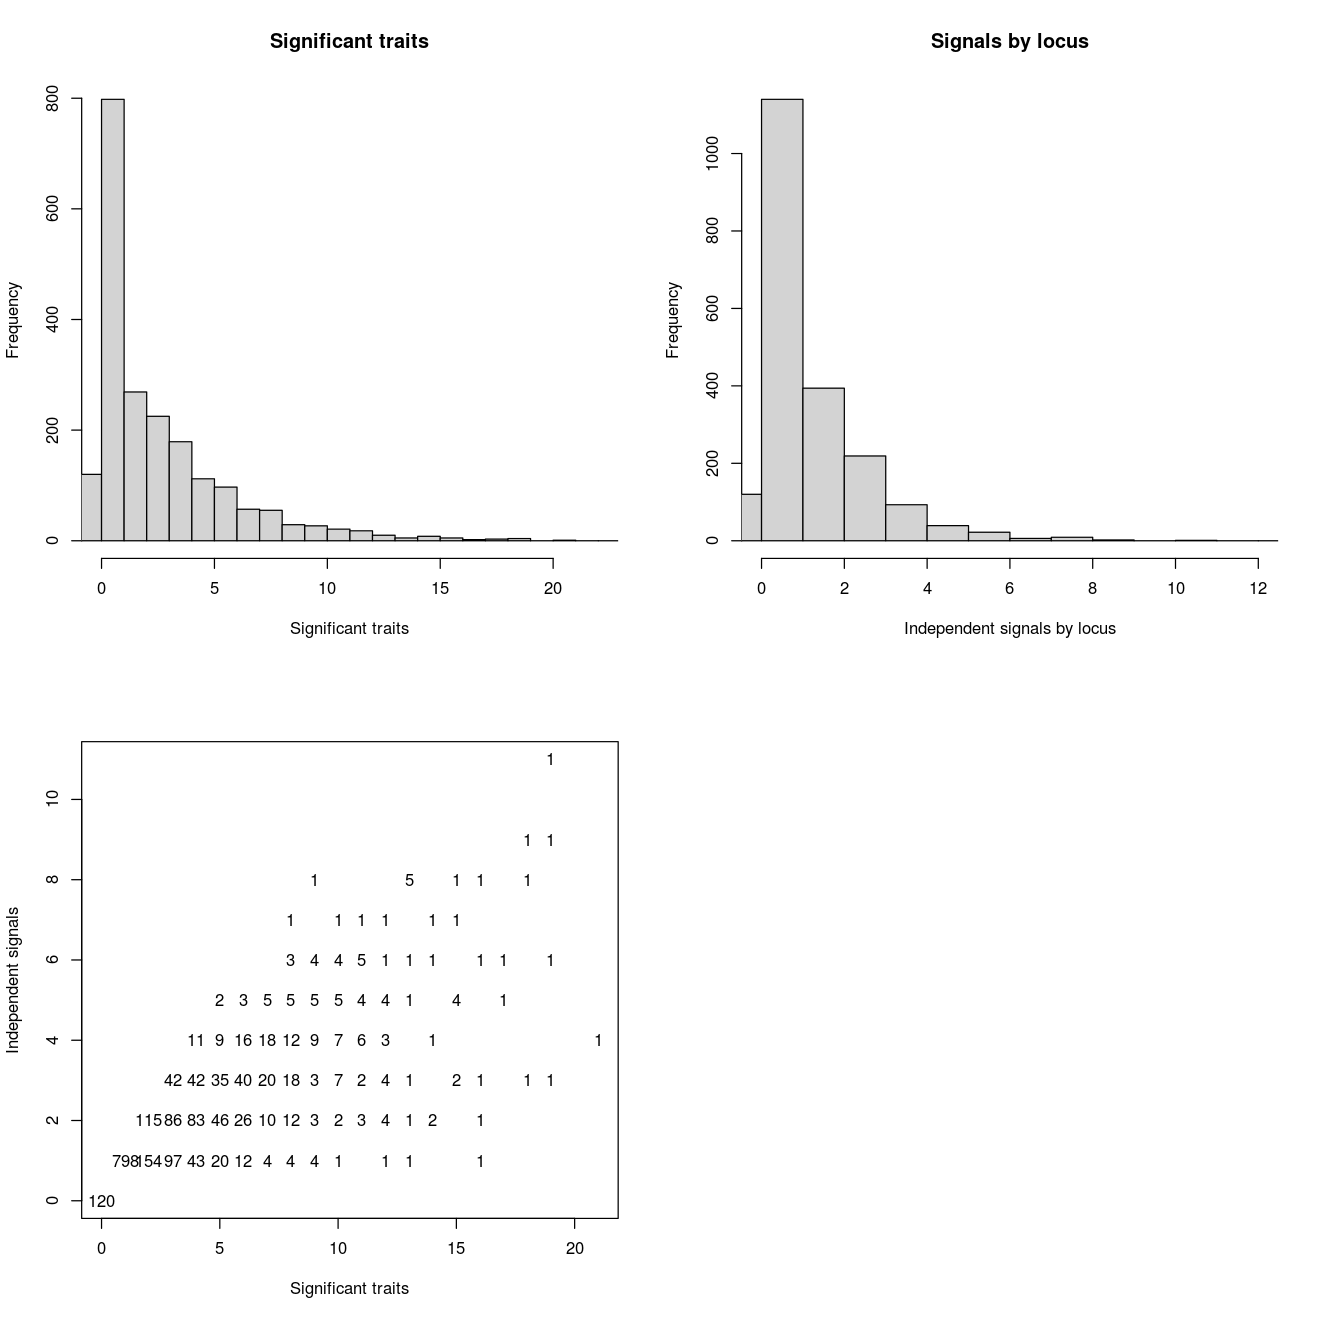

In [11]:
options(repr.plot.width = 11, repr.plot.height = 11)
layout(rbind(1:2, 3:4))
hist(moloc_df$n_signif , breaks = -1:nrow(manifest), main = "Significant traits", xlim = c(0, max(moloc_df$n_signif ) + 1), xlab = "Significant traits")
hist(moloc_df$n_signals, breaks = -1:nrow(manifest), main = "Signals by locus"  , xlim = c(0, max(moloc_df$n_signals) + 1), xlab = "Independent signals by locus")


moloc2c = aggregate(locus ~ n_signif + n_signals, data = moloc_df, FUN = length)
plot(moloc2c$n_signif, moloc2c$n_signals, type = "n", xlab = "Significant traits", ylab = "Independent signals")

text(x = moloc2c$n_signif, y = moloc2c$n_signals, labels = moloc2c$locus, cex = 1)


In [12]:
str(moloc_df)

'data.frame':	2045 obs. of  34 variables:
 $ locus                                         : chr  "1_965800_2544414" "1_2592477_2853372" "1_2884087_3089456" "1_3205016_3441796" ...
 $ chrom                                         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ from                                          : int  965800 2592477 2884087 3205016 6148182 6544723 7622595 8290051 9235173 9830927 ...
 $ to                                            : int  2544414 2853372 3089456 3441796 6406912 6879372 7901372 8995448 9556513 10934579 ...
 $ size                                          : int  1578614 260895 205369 236780 258730 334649 278777 705397 321340 1103652 ...
 $ n_signif                                      : int  8 1 1 4 2 3 3 4 4 11 ...
 $ n_signals                                     : int  7 1 1 1 2 1 1 1 3 2 ...
 $ biomarkers-30600-both_sexes-irnt              : num  6.32e-16 2.25e-03 1.09e-05 1.69e-04 2.68e-03 ...
 $ biomarkers-30680-both_sexes-irnt              : num  1.92e

In [13]:
library(pheatmap)

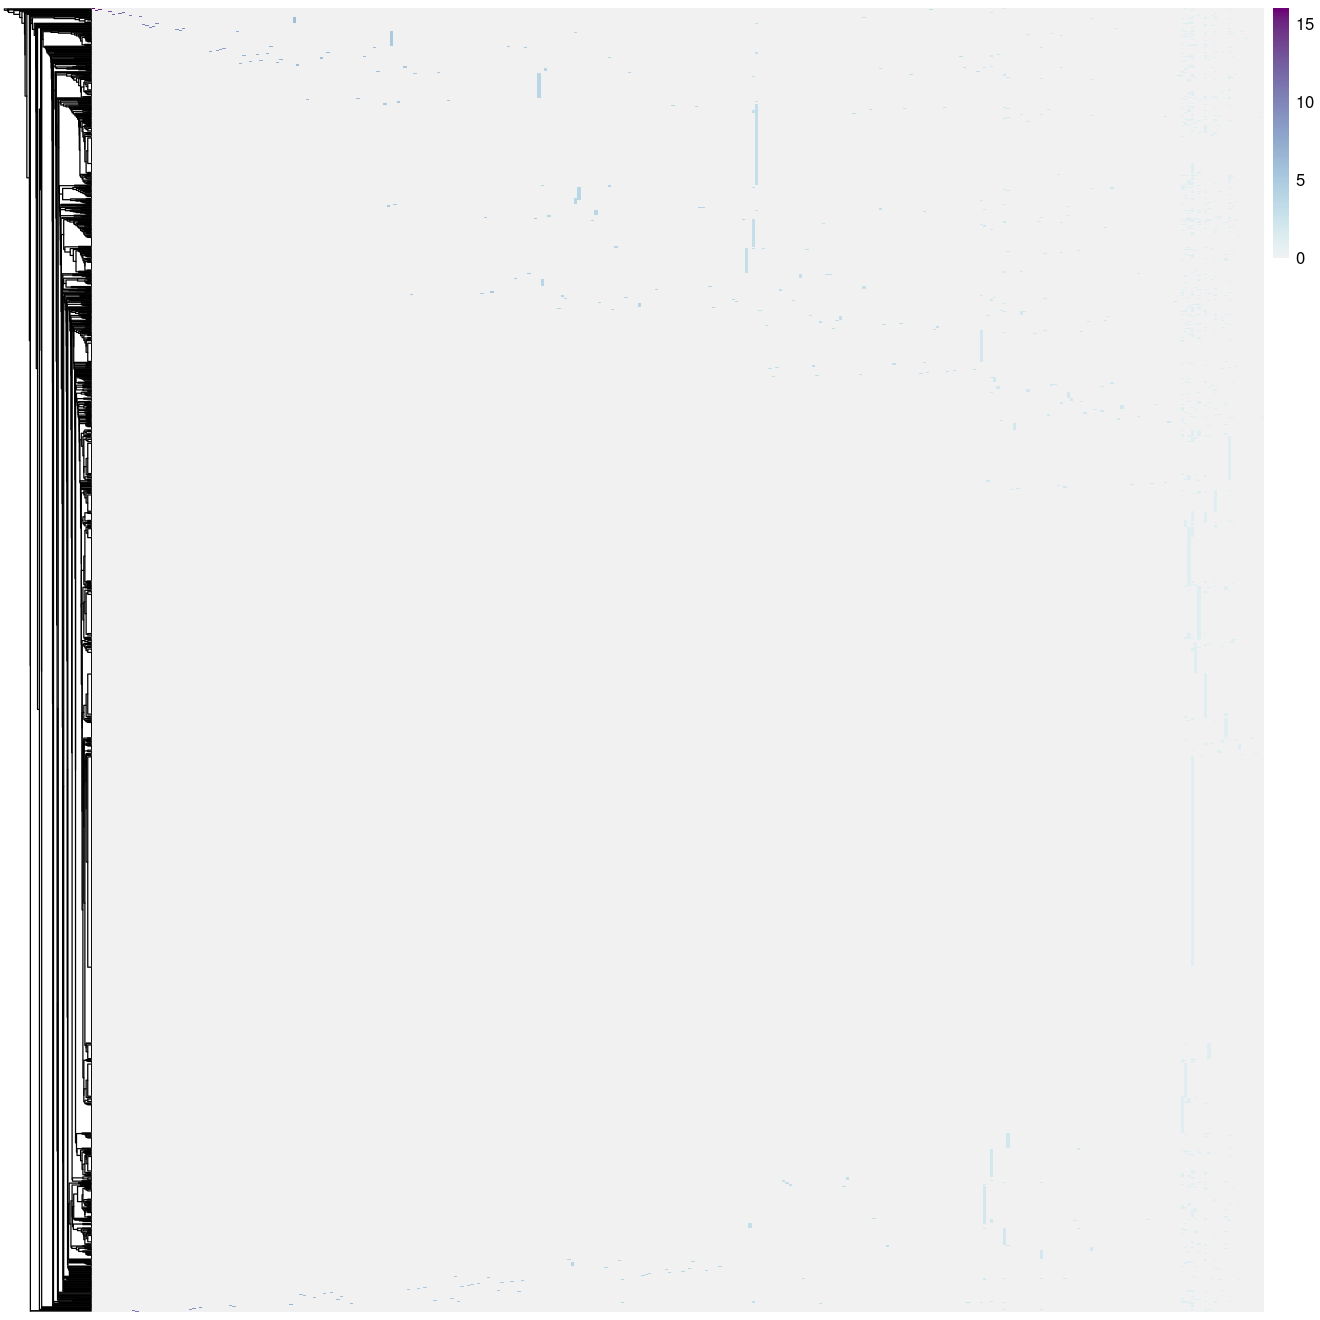

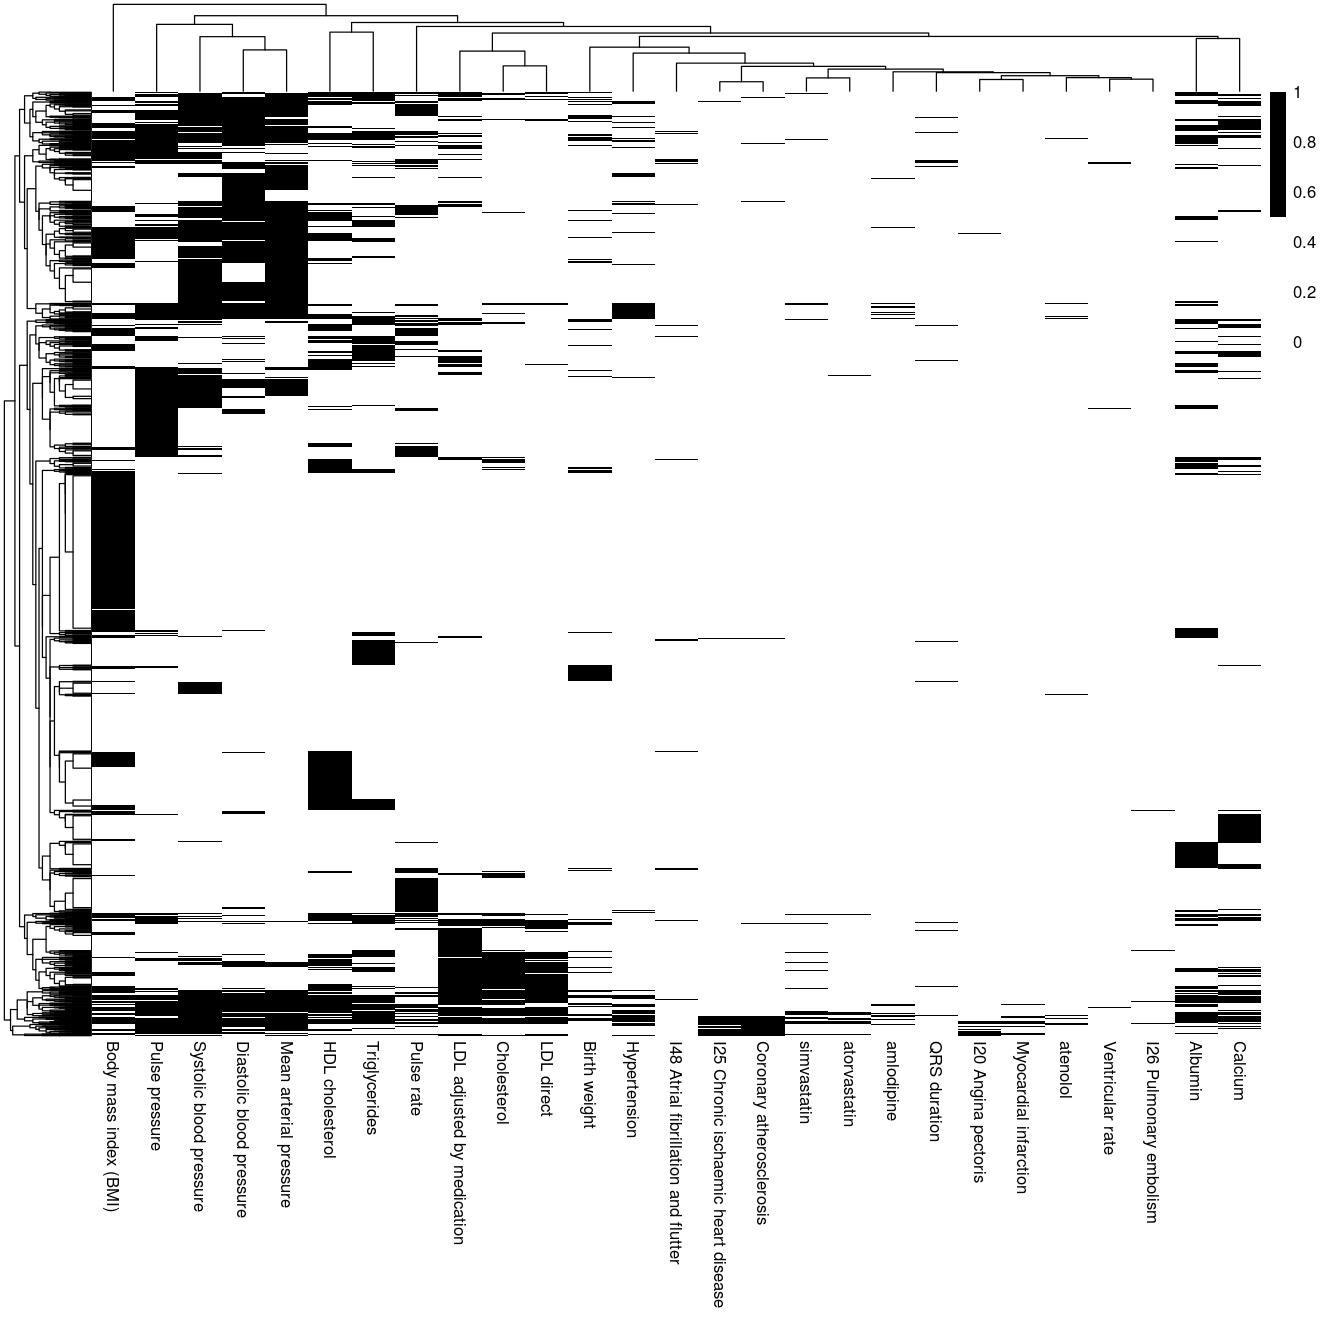

In [14]:
options(repr.plot.width = 11, repr.plot.height = 11)
pheatmap(as.matrix(moloc2signals), color = sequential_hcl(palette = "Purple-Blue", n = 100, rev = TRUE), cluster_rows = TRUE , cluster_cols = FALSE, show_colnames = FALSE, show_rownames = FALSE)

toplot           = moloc_df[ ,manifest$id]
colnames(toplot) = manifest$name
toplot           = as.matrix(toplot)
toplot           = apply(toplot, 1:2, function(x){ifelse(test = x <= 5e-8, yes = 1, no = 0)})
pheatmap(toplot, color = c("#ffffff", "#000000"), cluster_rows = TRUE , cluster_cols = TRUE, show_colnames = TRUE, show_rownames = FALSE)


# Combine data (Kohonen SOM)
- https://www.polarmicrobes.org/tutorial-self-organizing-maps-in-r/
- https://www.shanelynn.ie/self-organising-maps-for-customer-segmentation-using-r/

In [15]:
library(kohonen)
library(tempR)


In [16]:
tosom_list = lapply(loci$locus, function(locus)
{
    x             = moloc_list[[locus]][["ppa"]]
    out           = as.data.frame(matrix(0, nrow = length(x), ncol = nrow(manifest)))
    colnames(out) = manifest$id
    mynames       = c()
    
    if(length(x) > 0)
    {
        mynames = paste(locus, 1:length(x), sep = ".")

        for(ii in 1: length(x))
        {
            this = x[[ii]]
            out[ii, this] = 1
        }
    }
    return(list(df = out, locus_ids = mynames))
})

tosom           = as.data.frame(rbindlist(lapply(tosom_list, function(x){x[["df"       ]]})), stringsAsFactors = FALSE)
rownames(tosom) = unlist                 (lapply(tosom_list, function(x){x[["locus_ids"]]})) 

In [17]:
set.seed(222)
somgrid_size = ceiling(sqrt(ncol(moloc2signals)))
somgrid_size = 20
g   = somgrid(xdim = somgrid_size, ydim = somgrid_size, topo = "hexagonal", toroidal = TRUE)
map = som(as.matrix(tosom), grid = g, alpha = c(0.05, 0.01))

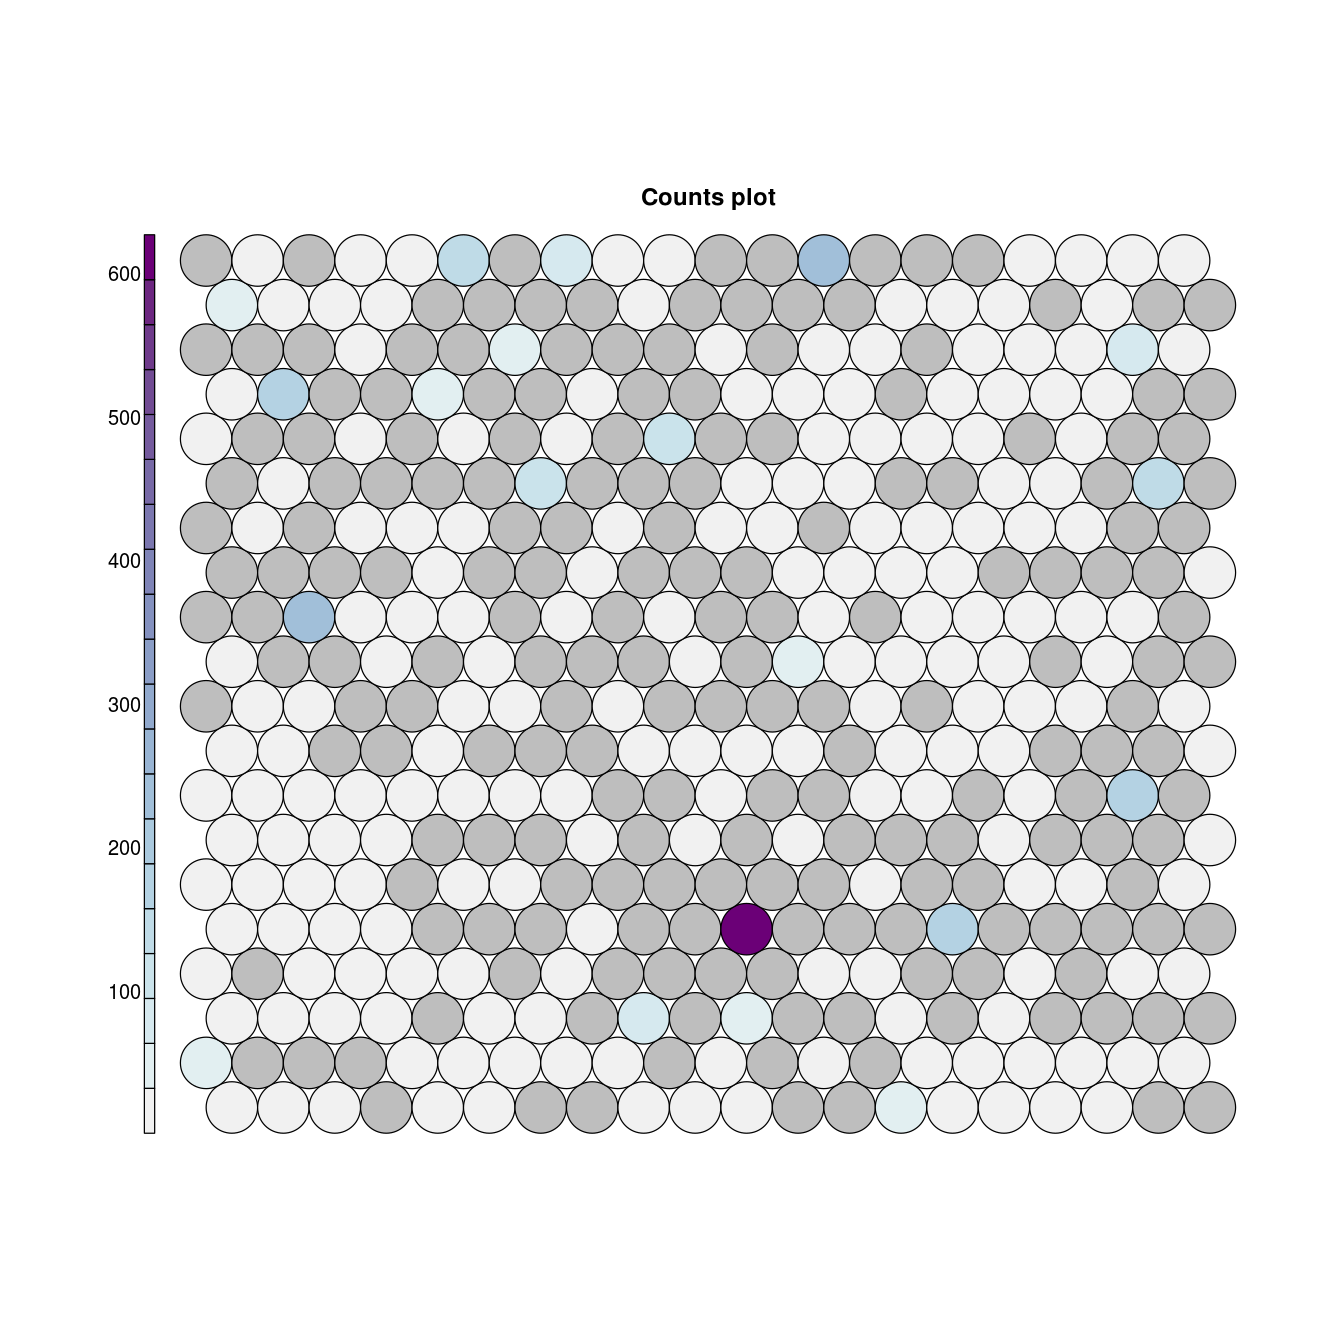

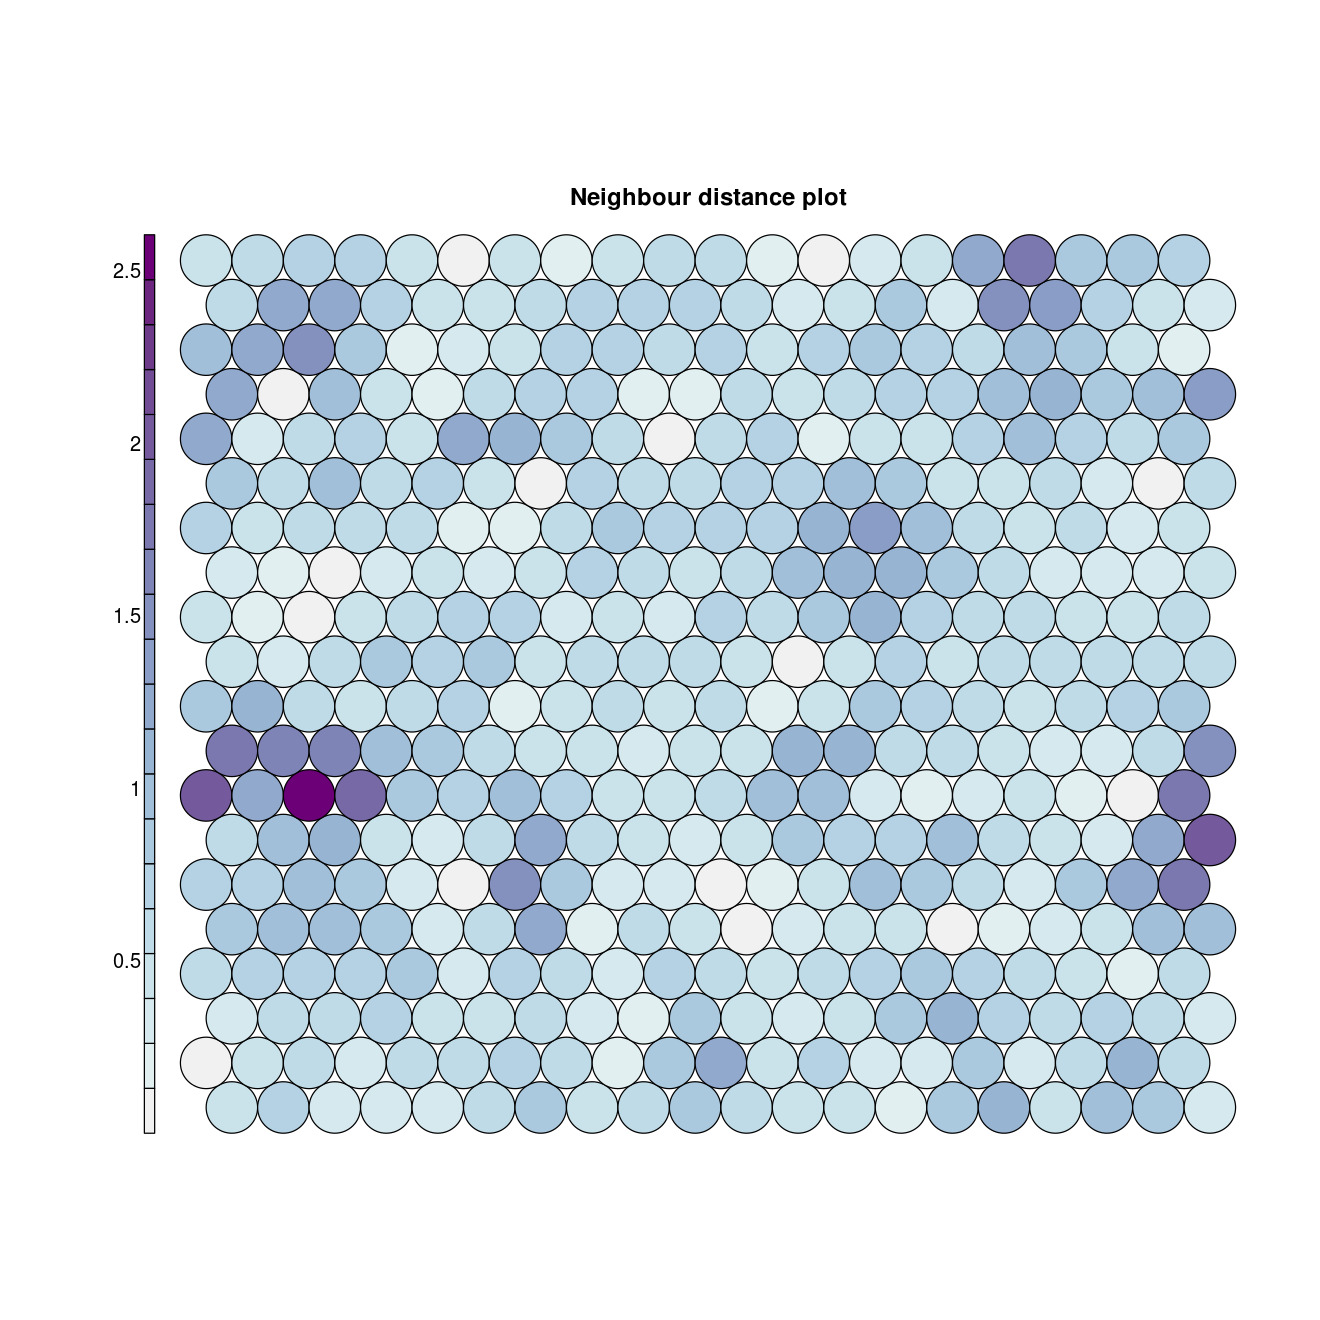

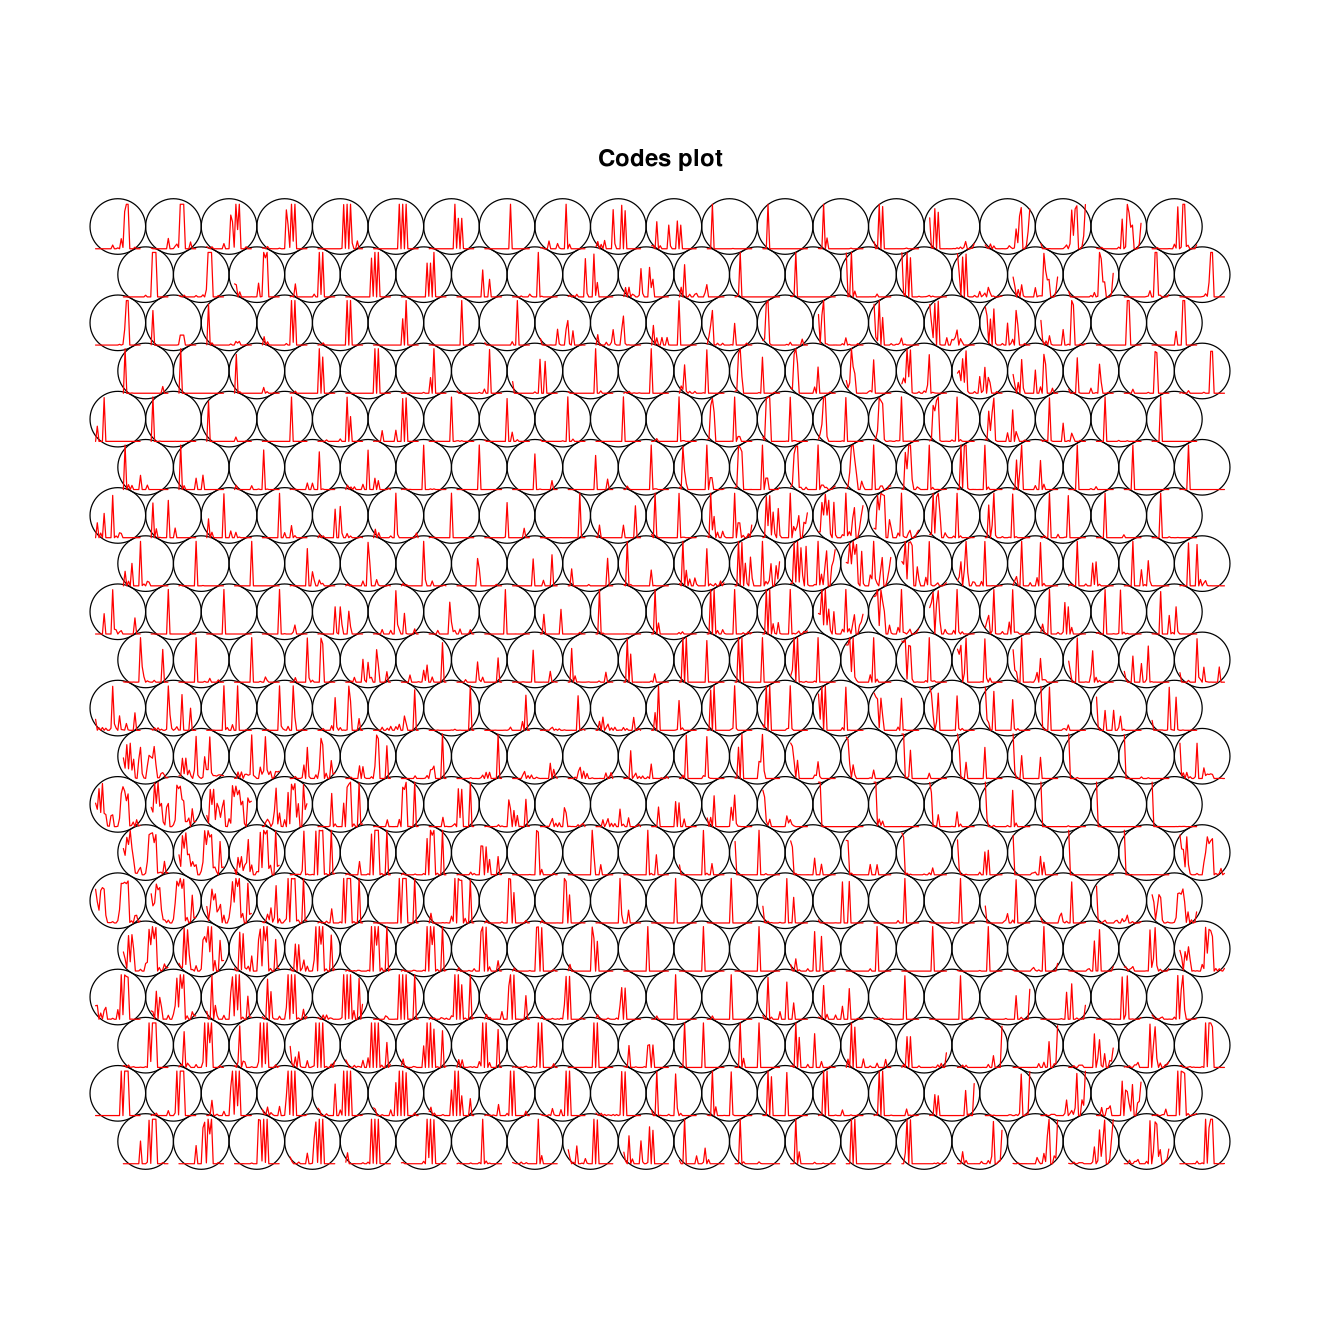

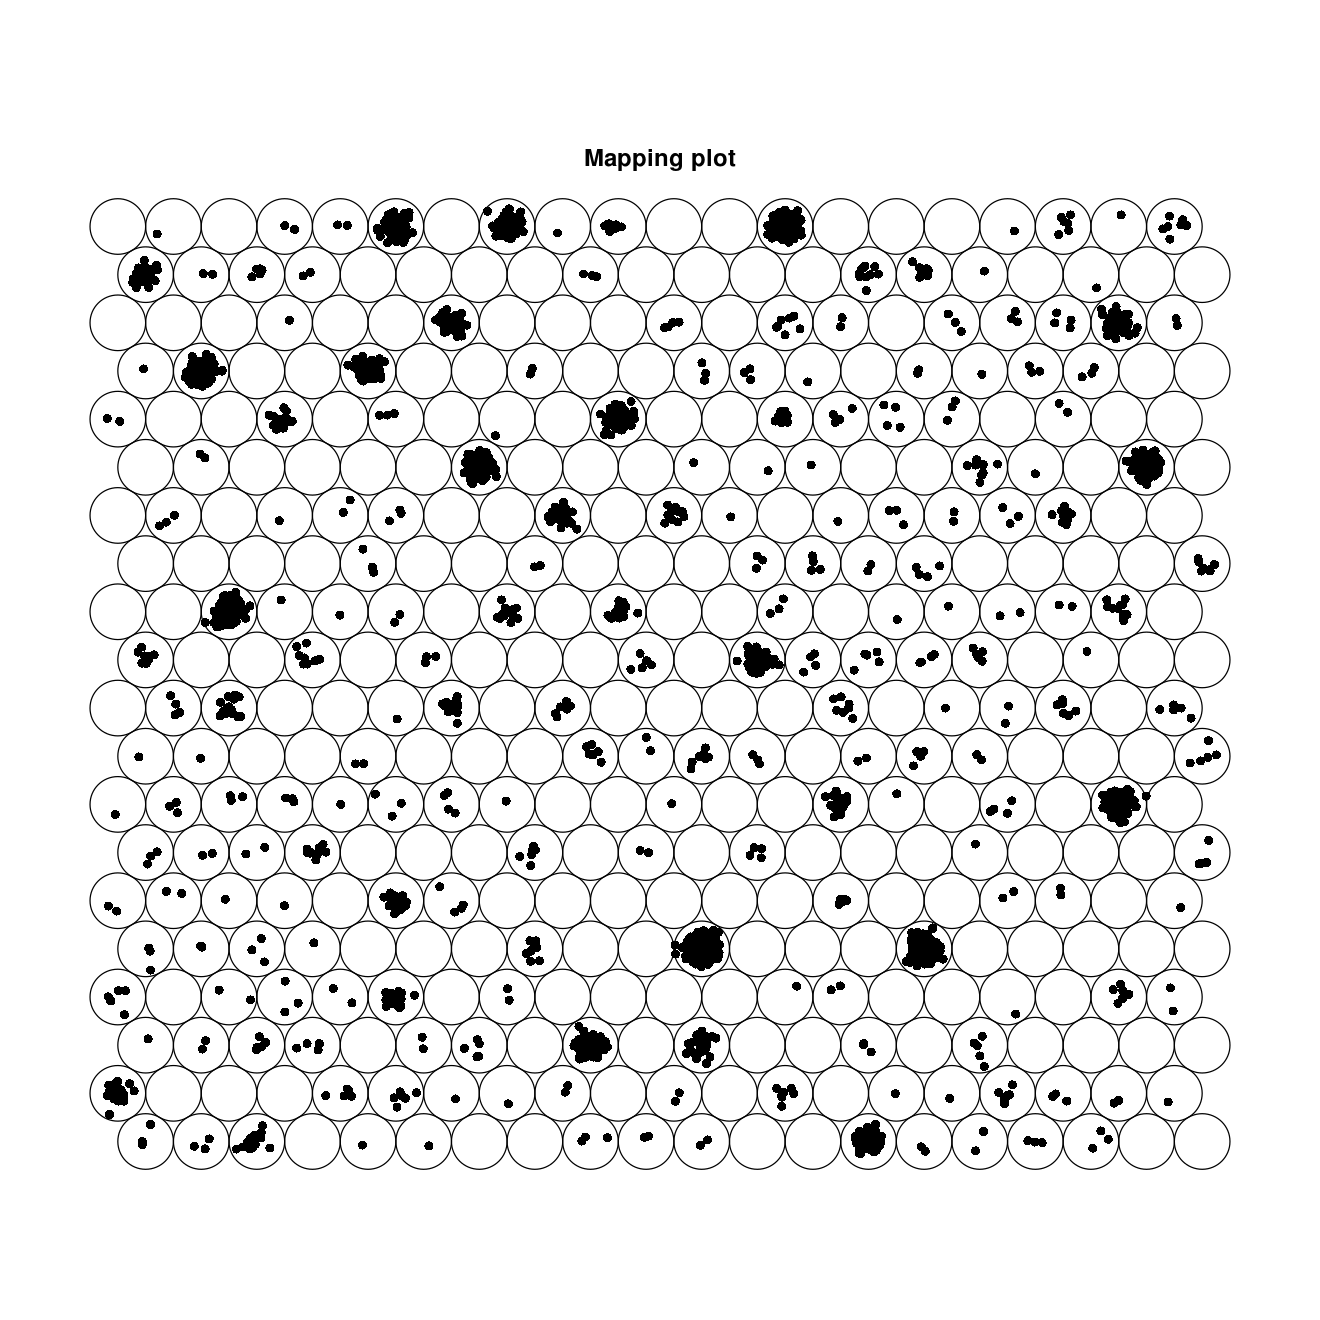

In [18]:
colors = function(n, alpha = 1)
{
    sequential_hcl(n = n, alpha = alpha, palette = "Purple-Blue", rev = TRUE)
}
options(repr.plot.width = 11, repr.plot.height = 11)
plot(map, type = 'counts'         , palette.name = colors, keepMargins = FALSE)
plot(map, type = 'dist.neighbours', palette.name = colors, keepMargins = FALSE)
plot(map, type = 'codes'          , palette.name = colors, keepMargins = FALSE)
plot(map, type = 'mapping'        , pchs = 16)


In [19]:
set.seed(222)
clusters_to_save = kmeans(x = map$codes[[1]], centers = 30, iter.max = 500, nstart = 10)
clusters         = clusters_to_save$cluster

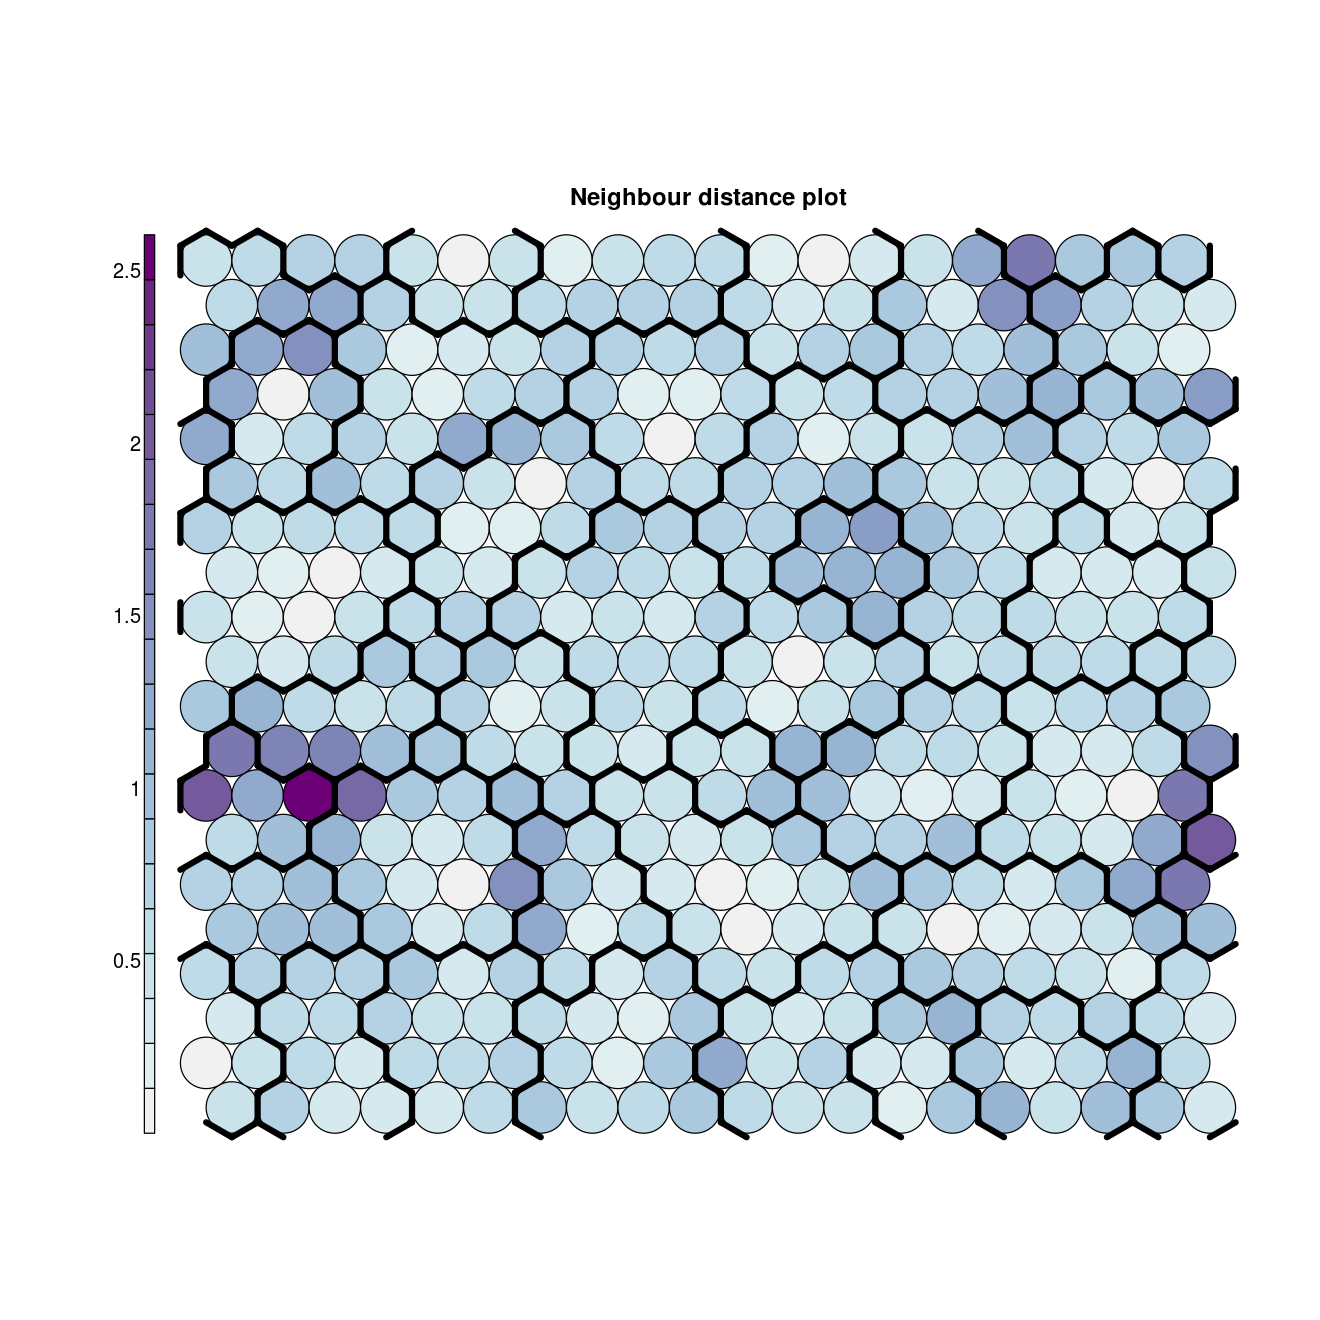

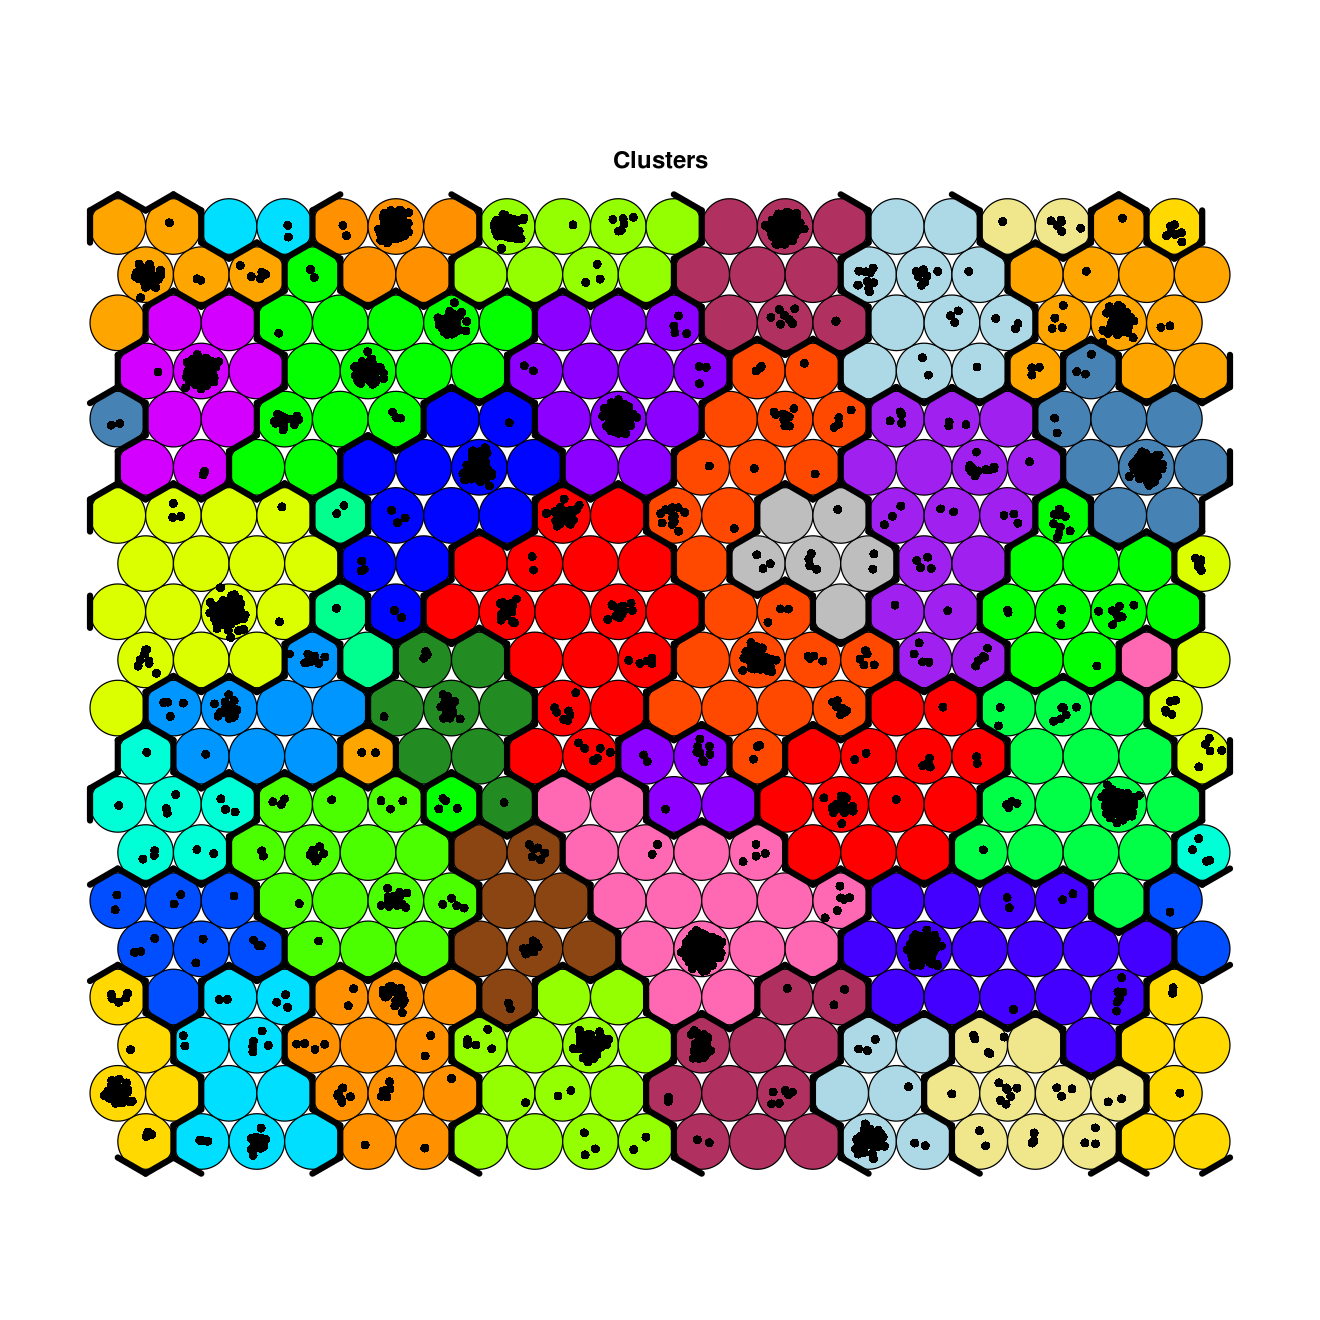

In [20]:
plotSOM = function(clusters)
{
    plot(map, type = 'dist.neighbours', palette.name = colors, pchs = 16)
    add.cluster.boundaries(map, clusters)
}

options(repr.plot.width = 11, repr.plot.height = 11)
plotSOM(clusters)

plot(map, type = "mapping", bgcol = pretty_palette(length(unique(clusters)))[clusters], main = "Clusters", pchs = 16) 
add.cluster.boundaries(map, clusters)

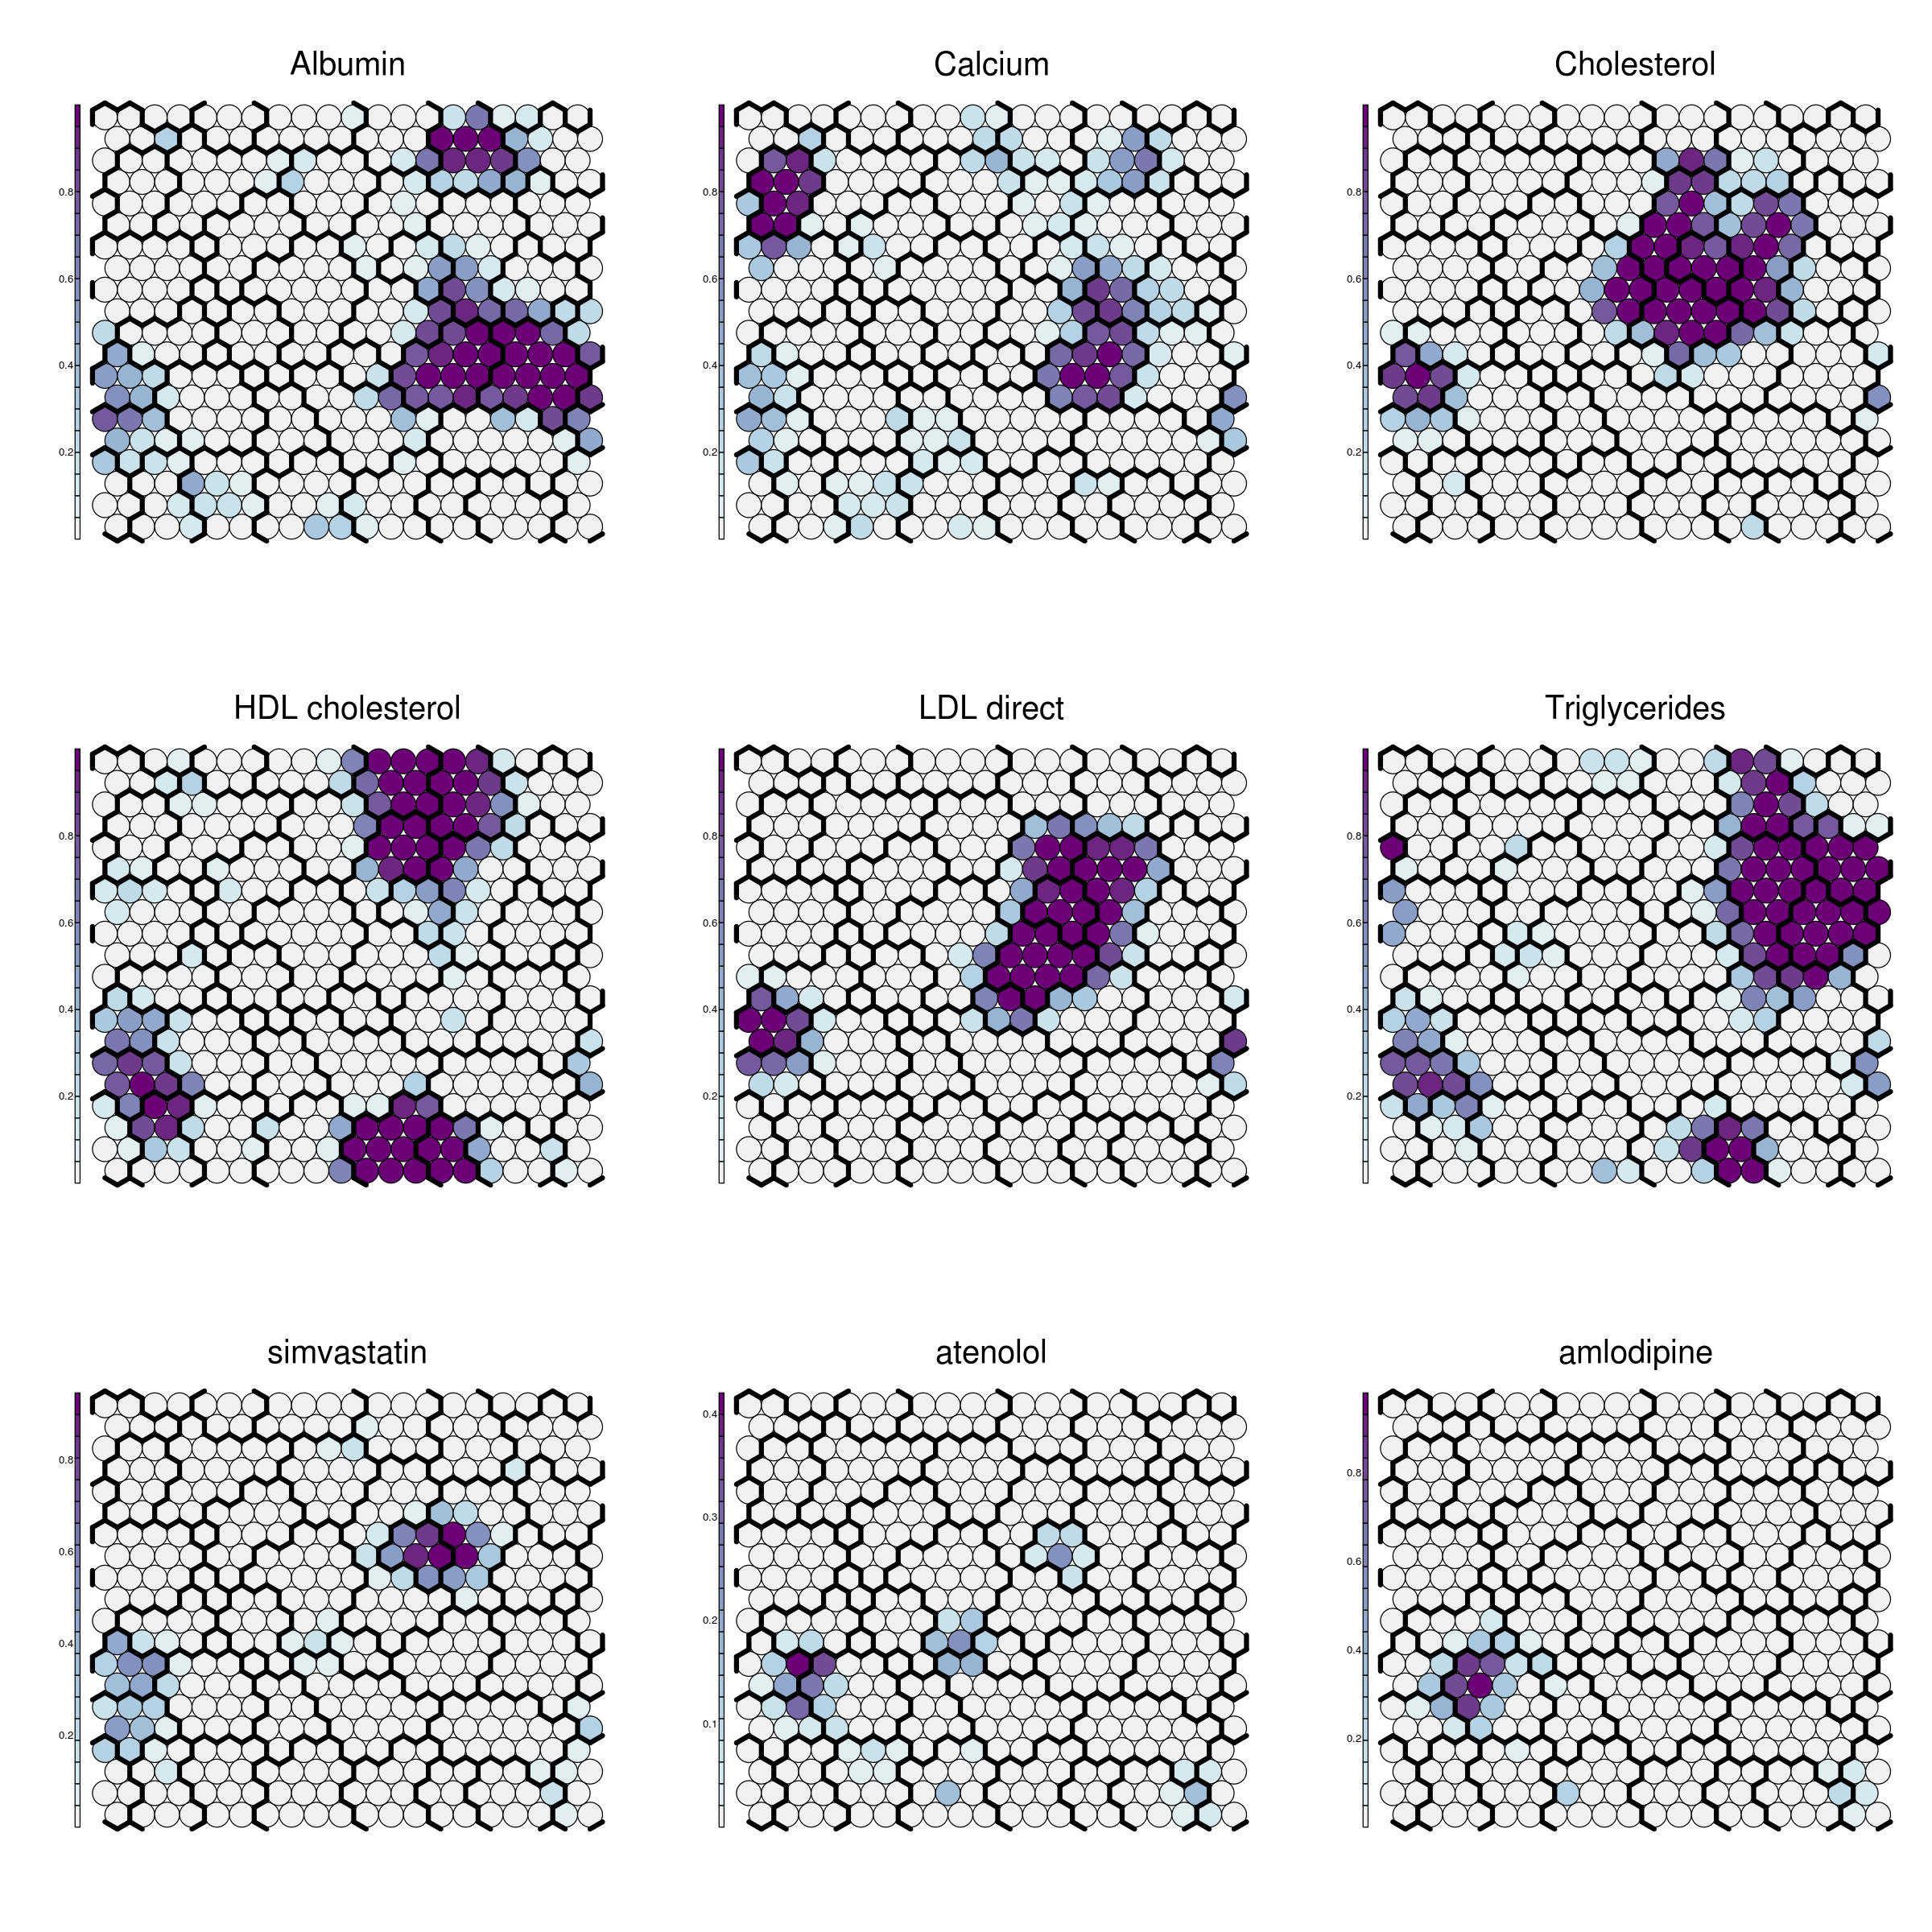

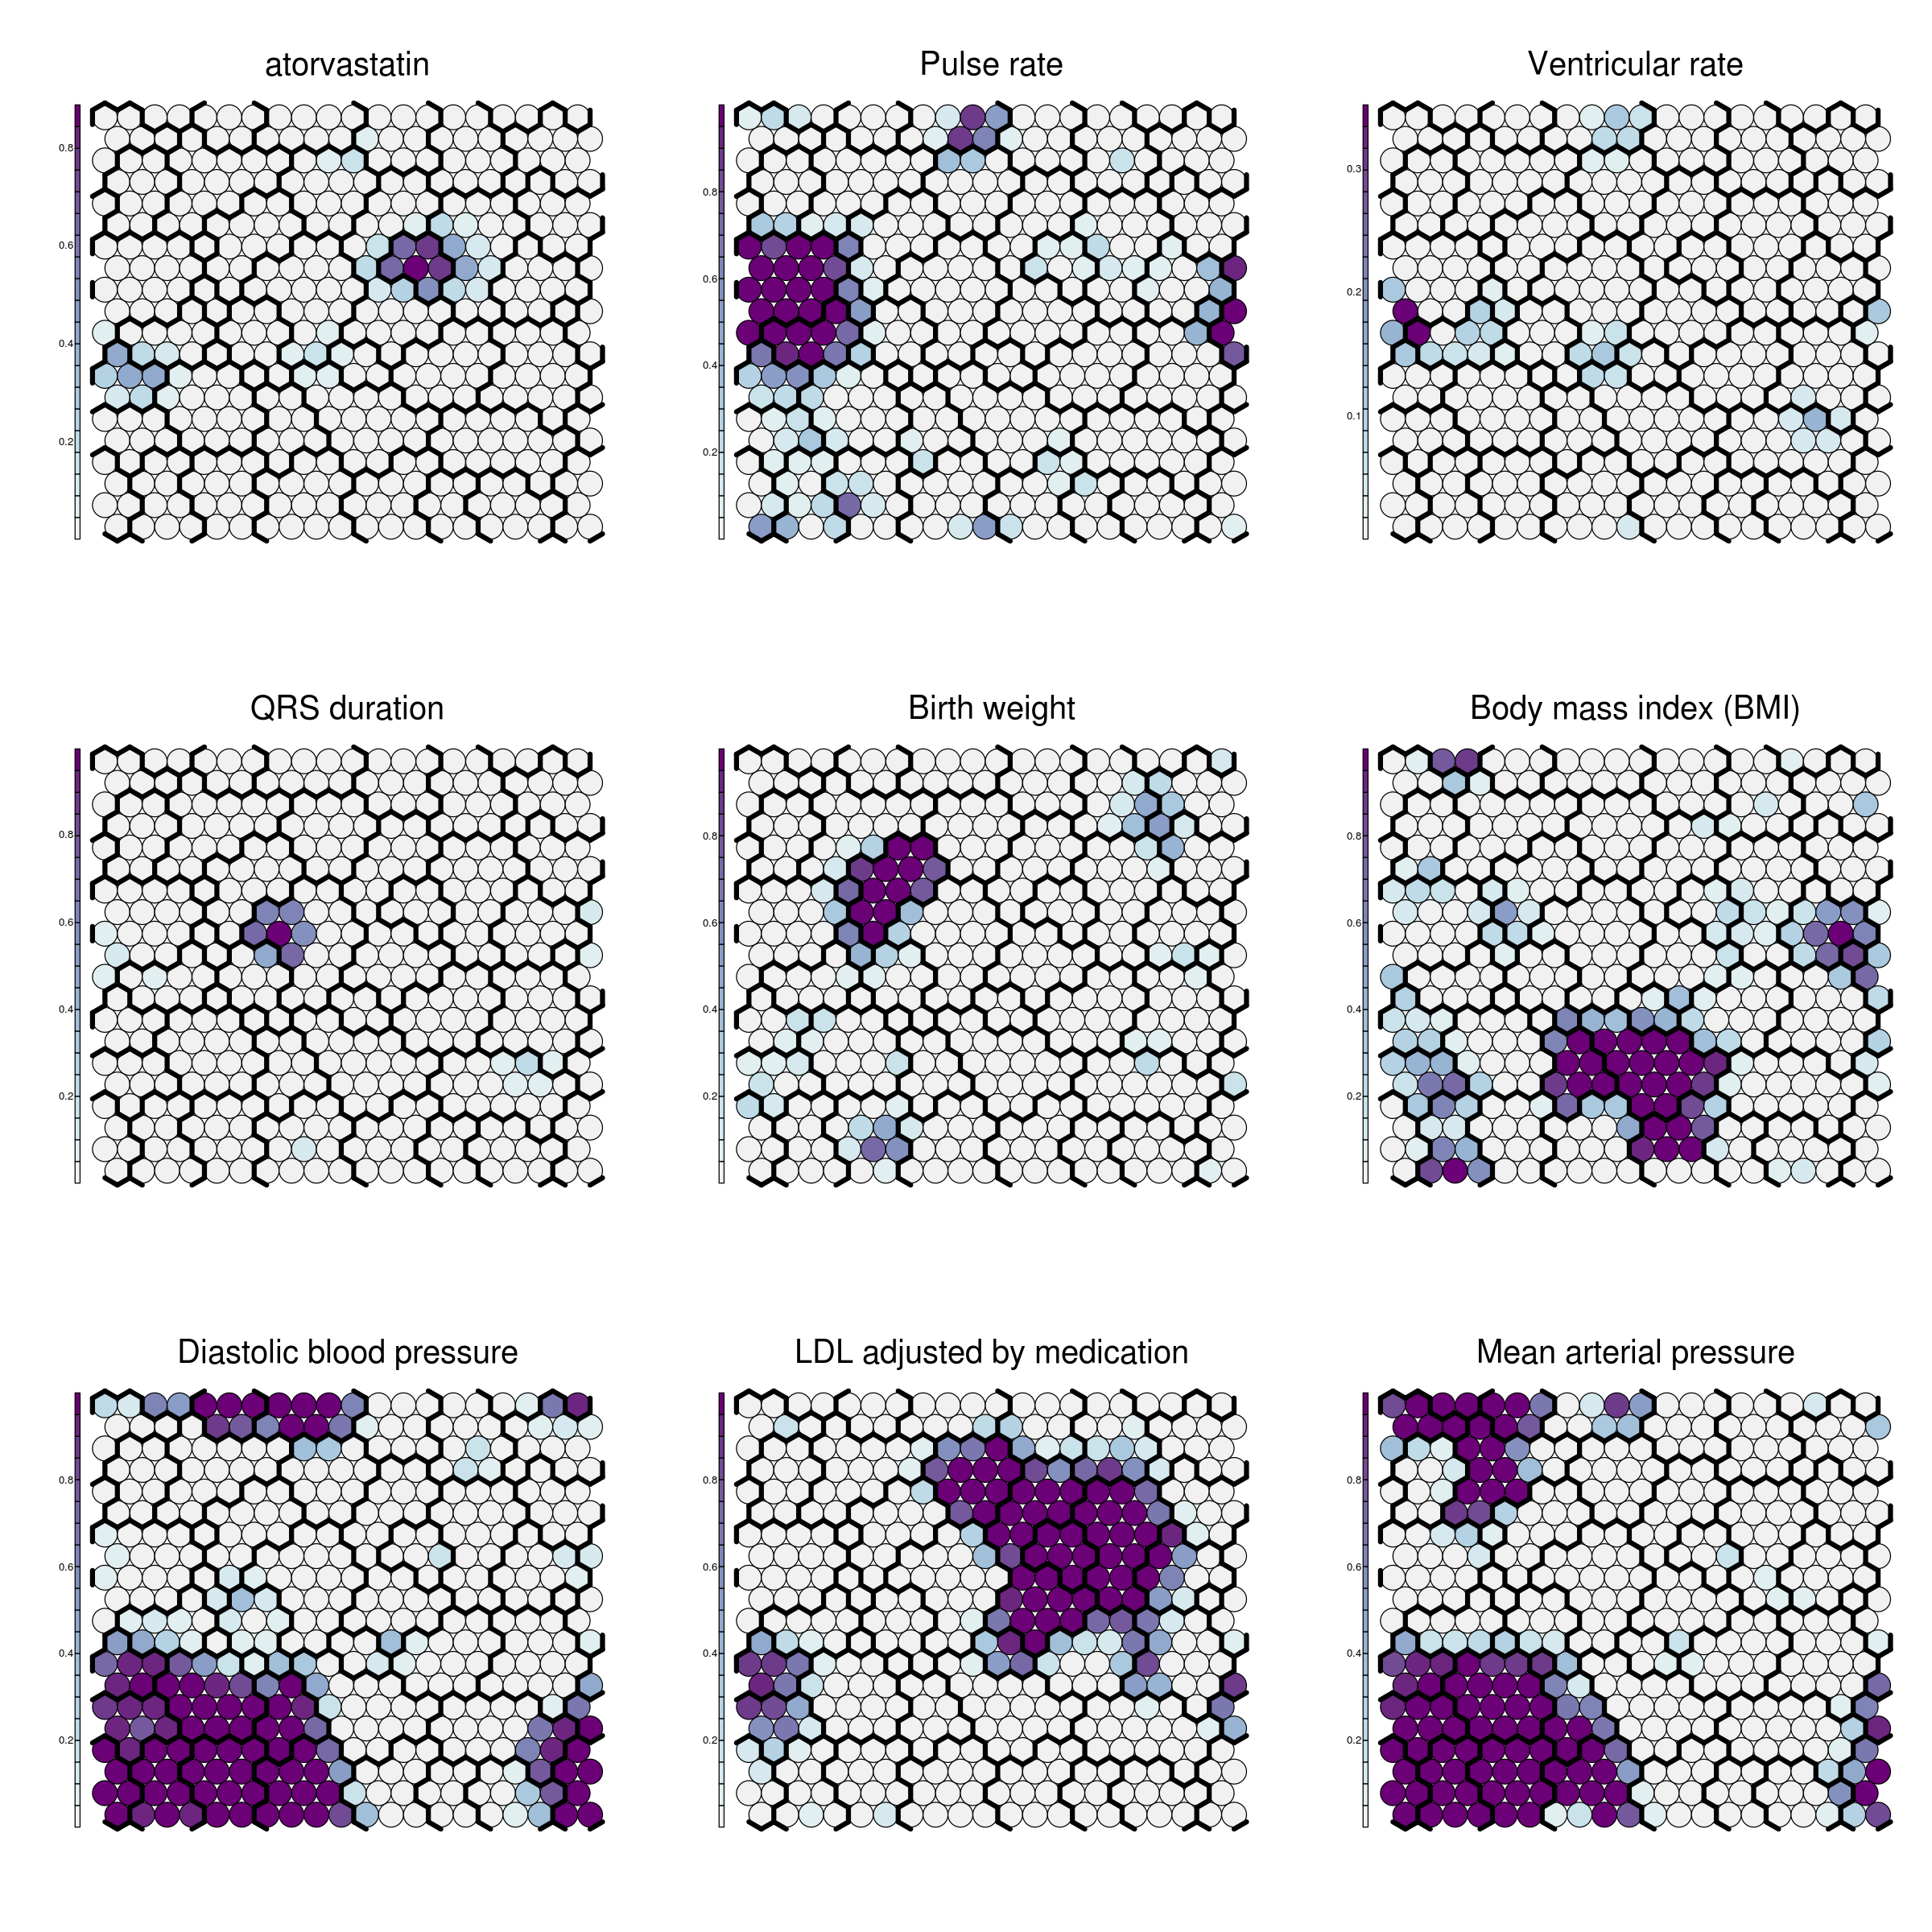

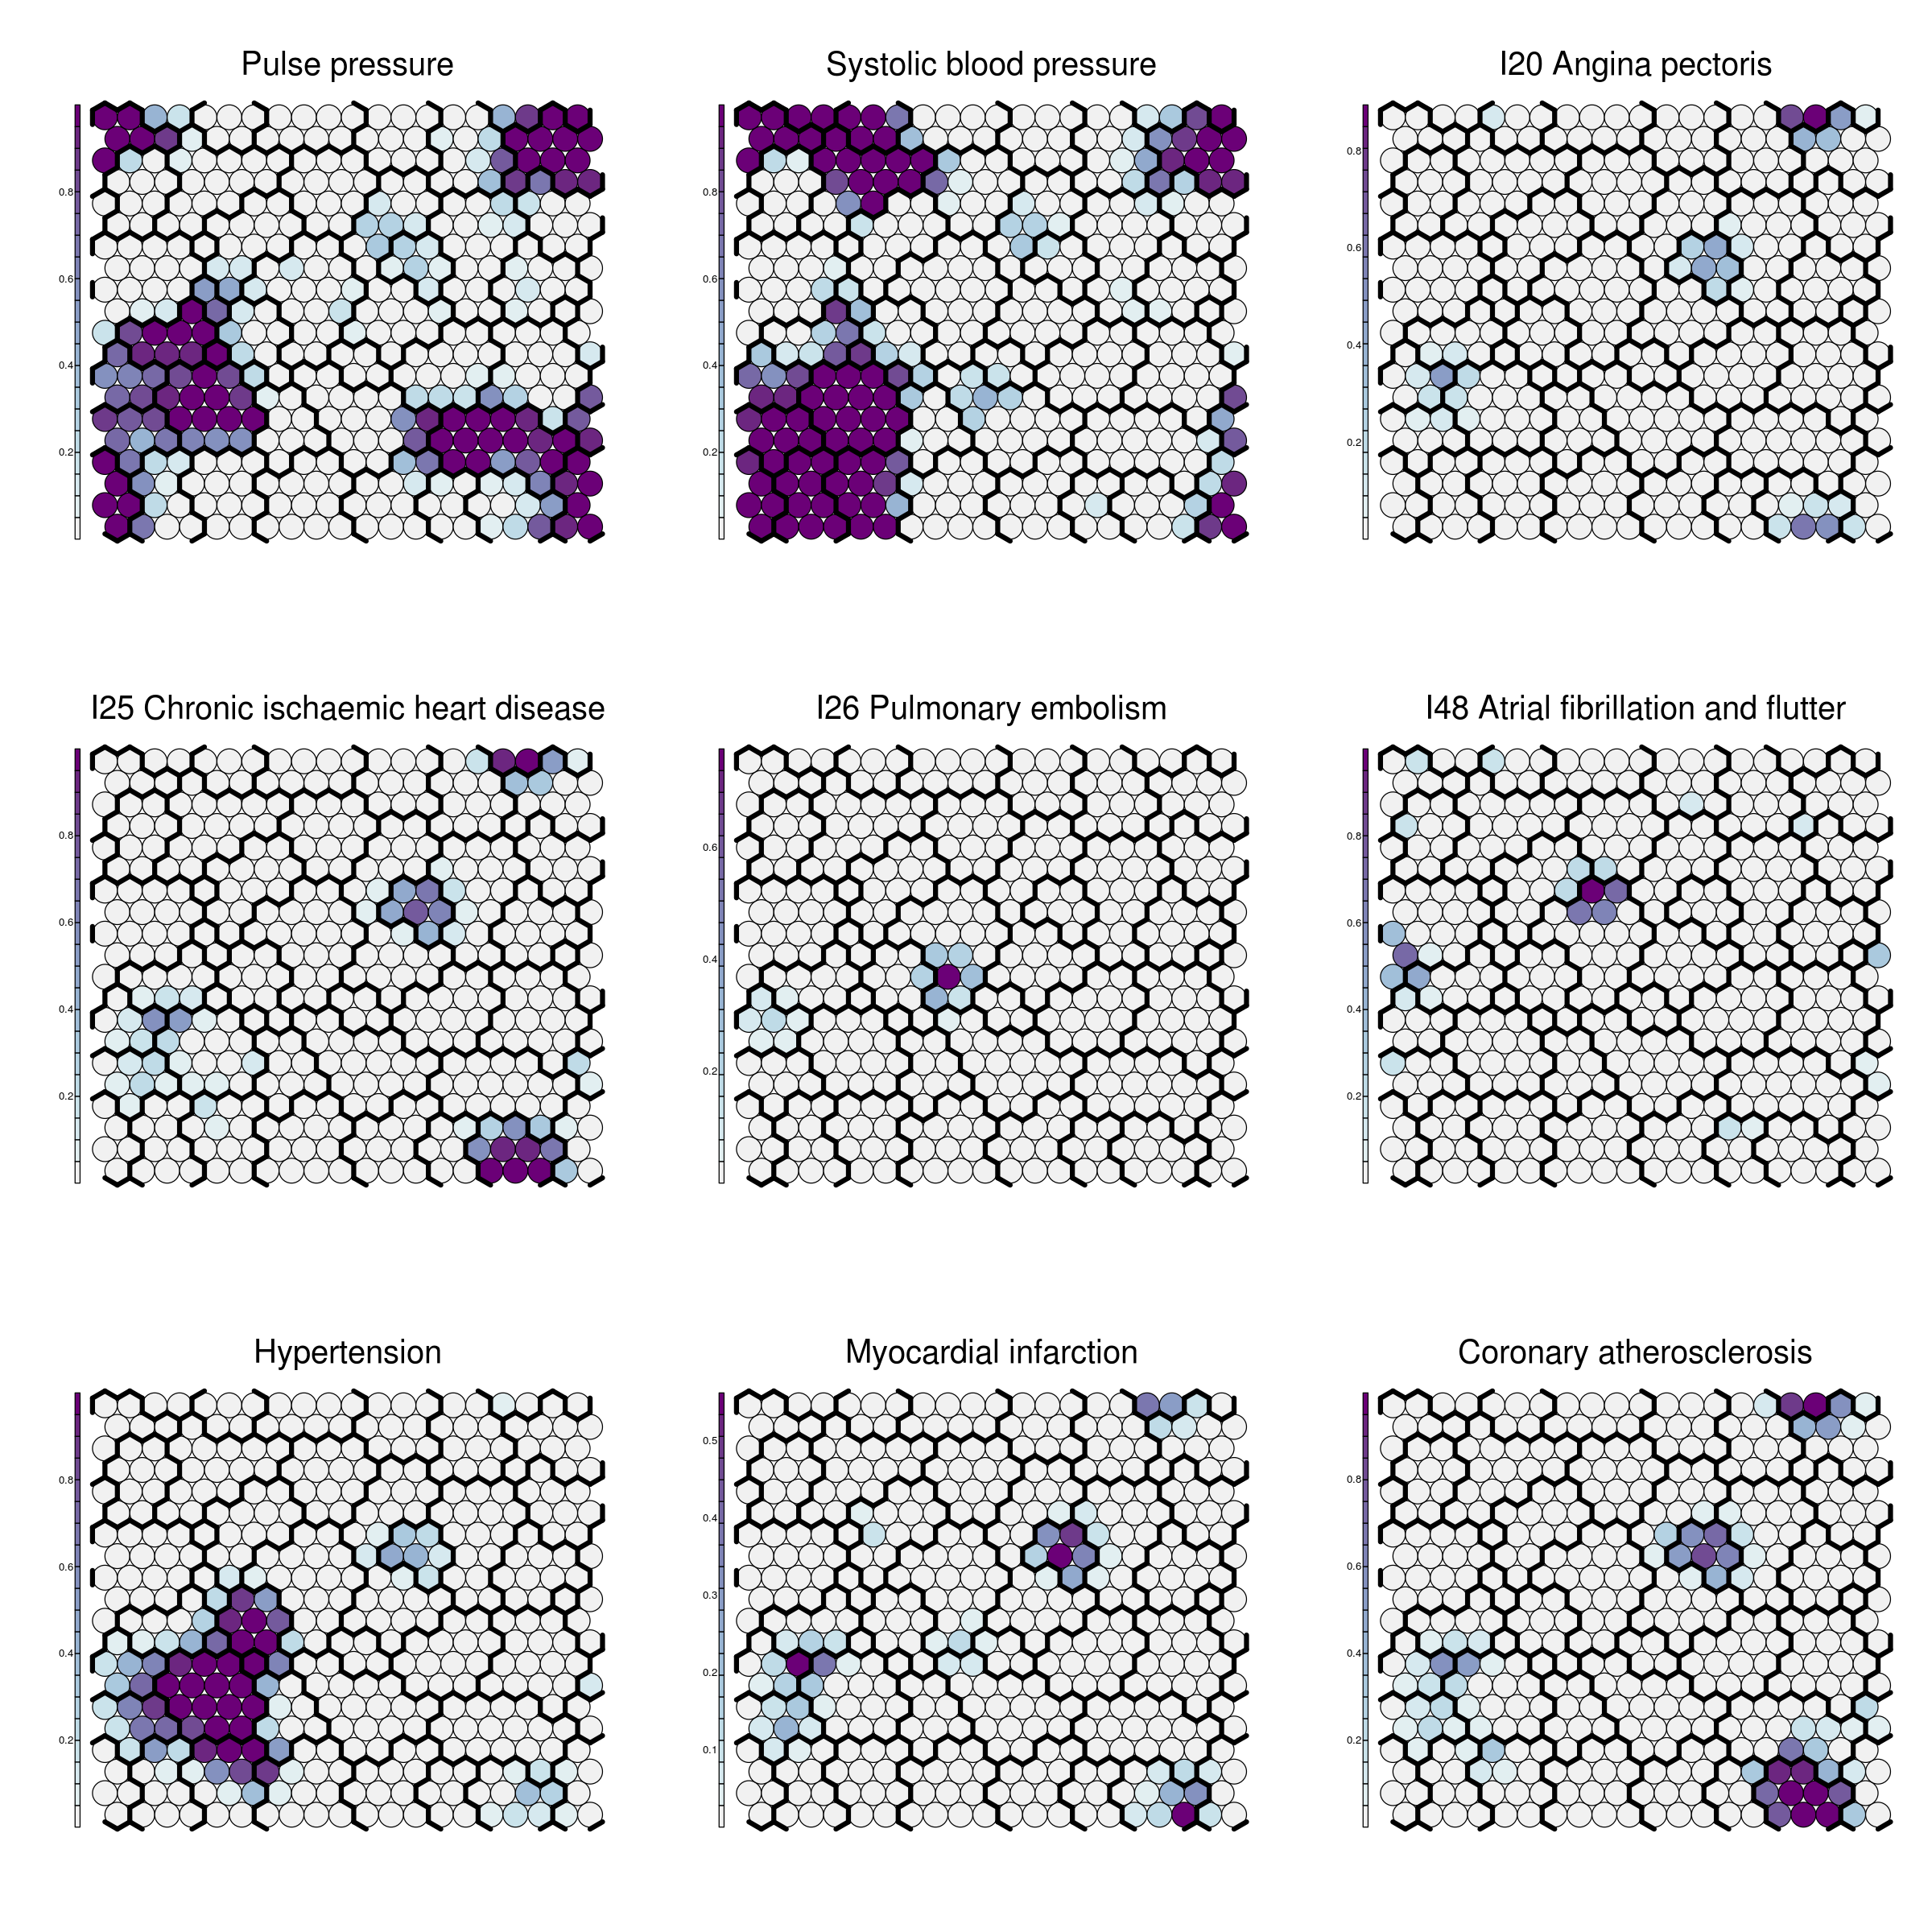

In [21]:
plot_som_trait = function(ii)
{
    plot(map, type = "property", property = getCodes(map)[,ii], palette.name = colors, main = "")
    mtext(text = manifest[ii, "name"], side = 3, line = -2, cex = 2)
    add.cluster.boundaries(map, clusters)
}

options(repr.plot.width = 20, repr.plot.height = 20)

layout(rbind(1:3, 4:6, 7:9))
invisible(lapply(1:nrow(manifest), plot_som_trait))


In [22]:
loci2class            = data.frame(id = rownames(tosom), locus = unlist(lapply(rownames(tosom), function(x){unlist(strsplit(x, "\\."))[[1]]})))
loci2class$som        = map$unit.classif
som2cluster           = cbind(data.frame(som = 1:length(clusters), cluster = clusters), as.data.frame(map$grid$pts))
trait2class           = as.data.frame(map$codes[[1]])
som2cluster_n         = data.frame(som = names(table(loci2class$som)), n_loci = as.numeric(table(loci2class$som)))
som2cluster           = merge(som2cluster, som2cluster_n, all.x = TRUE)

som2cluster[ is.na(som2cluster$n_loci) == TRUE, "n_loci"] = 0

som2cluster           = som2cluster[order(som2cluster$som),]
loci2class            = merge(loci2class, som2cluster[,c("som", "cluster")])
toplot                = tosom

moloc_map_list = list(moloc_df    = moloc_df,
                      som         = list(input    = tosom,
                                         som_grid = g,
                                         map      = map,
                                         kmeans   = clusters_to_save,
                                         clusters = clusters
                                        ),
                      loci2class  = loci2class,
                      trait2class = trait2class
                     )

saveRDS(moloc_map_list, "pipeline/2.2.moloc/moloc_map_list.rds")

colnames(toplot)      = manifest$name
colnames(trait2class) = manifest$name
#loci2class            = loci

str(loci2class)
str(trait2class)
str(som2cluster)


'data.frame':	3427 obs. of  4 variables:
 $ som    : num  1 1 1 2 2 2 3 3 3 3 ...
 $ id     : chr  "2_174830016_175675066.1" "16_14277712_16384360.1" "1_43659733_44170691.1" "7_74744193_75300523.1" ...
 $ locus  : chr  "2_174830016_175675066" "16_14277712_16384360" "1_43659733_44170691" "7_74744193_75300523" ...
 $ cluster: int  16 16 16 24 24 24 24 24 24 24 ...
'data.frame':	400 obs. of  27 variables:
 $ Albumin                            : num  1.36e-06 4.30e-04 8.61e-04 1.50e-01 3.51e-02 ...
 $ Calcium                            : num  8.55e-07 1.23e-05 4.44e-04 5.21e-02 2.46e-01 ...
 $ Cholesterol                        : num  1.23e-19 2.40e-23 3.16e-26 1.26e-30 5.39e-47 ...
 $ HDL cholesterol                    : num  6.73e-05 3.29e-04 3.68e-04 1.31e-04 2.57e-12 ...
 $ LDL direct                         : num  1.23e-19 6.90e-26 2.60e-29 1.26e-30 2.97e-47 ...
 $ Triglycerides                      : num  6.95e-12 5.22e-04 8.15e-04 3.80e-02 2.37e-03 ...
 $ simvastatin                

In [1]:
options(repr.plot.width = 11, repr.plot.height = 11)
pheatmap(t(as.matrix(trait2class)), color = sequential_hcl(palette = "Purple-Blue", n = 100, rev = TRUE), cluster_rows = TRUE , cluster_cols = TRUE, show_colnames = FALSE, show_rownames = TRUE)

toheat           = trait2class
toheat           = cbind(toheat, som2cluster[,c("cluster", "n_loci")])
toheat           = toheat[ toheat$n_loci > 0,]
toheat$n_loci    = NULL
toheat           = aggregate(. ~ cluster, data = toheat, FUN = mean)
rownames(toheat) = toheat$cluster
toheat$cluster   = NULL

pheatmap(t(as.matrix(toheat)), color = sequential_hcl(palette = "Purple-Blue", n = 100, rev = TRUE), cluster_rows = TRUE , cluster_cols = TRUE, show_colnames = TRUE, show_rownames = TRUE)



ERROR: Error in pheatmap(t(as.matrix(trait2class)), color = sequential_hcl(palette = "Purple-Blue", : could not find function "pheatmap"


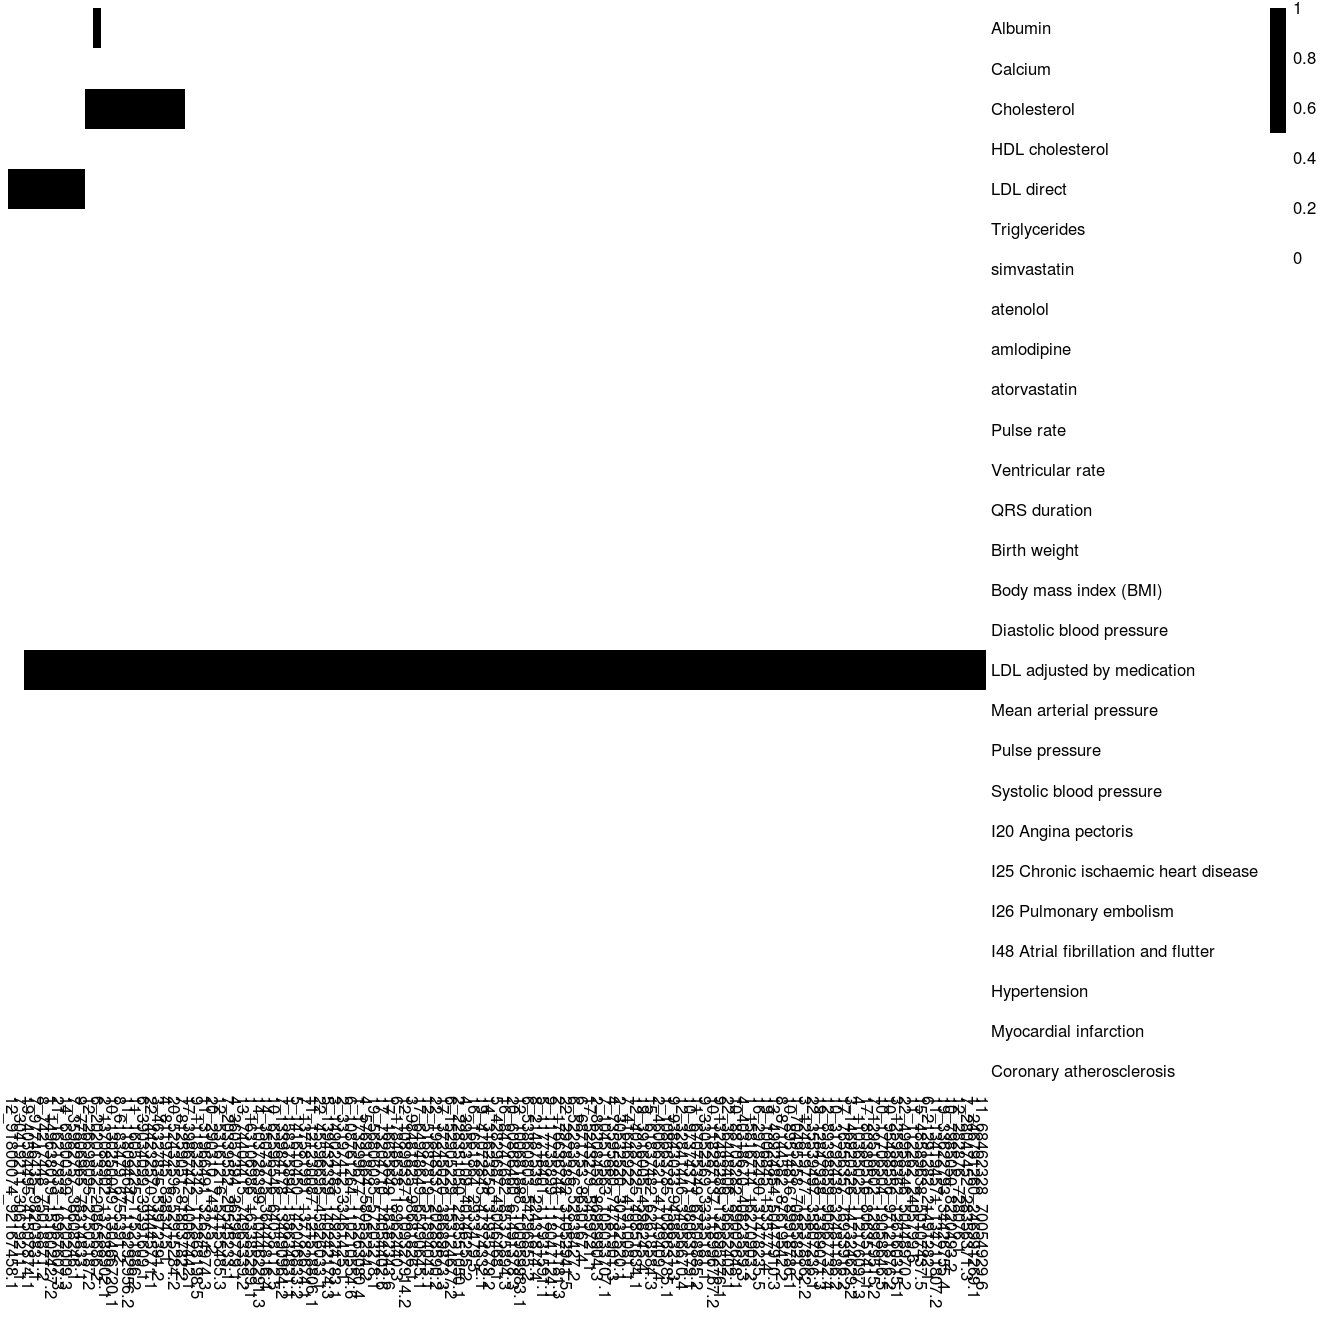

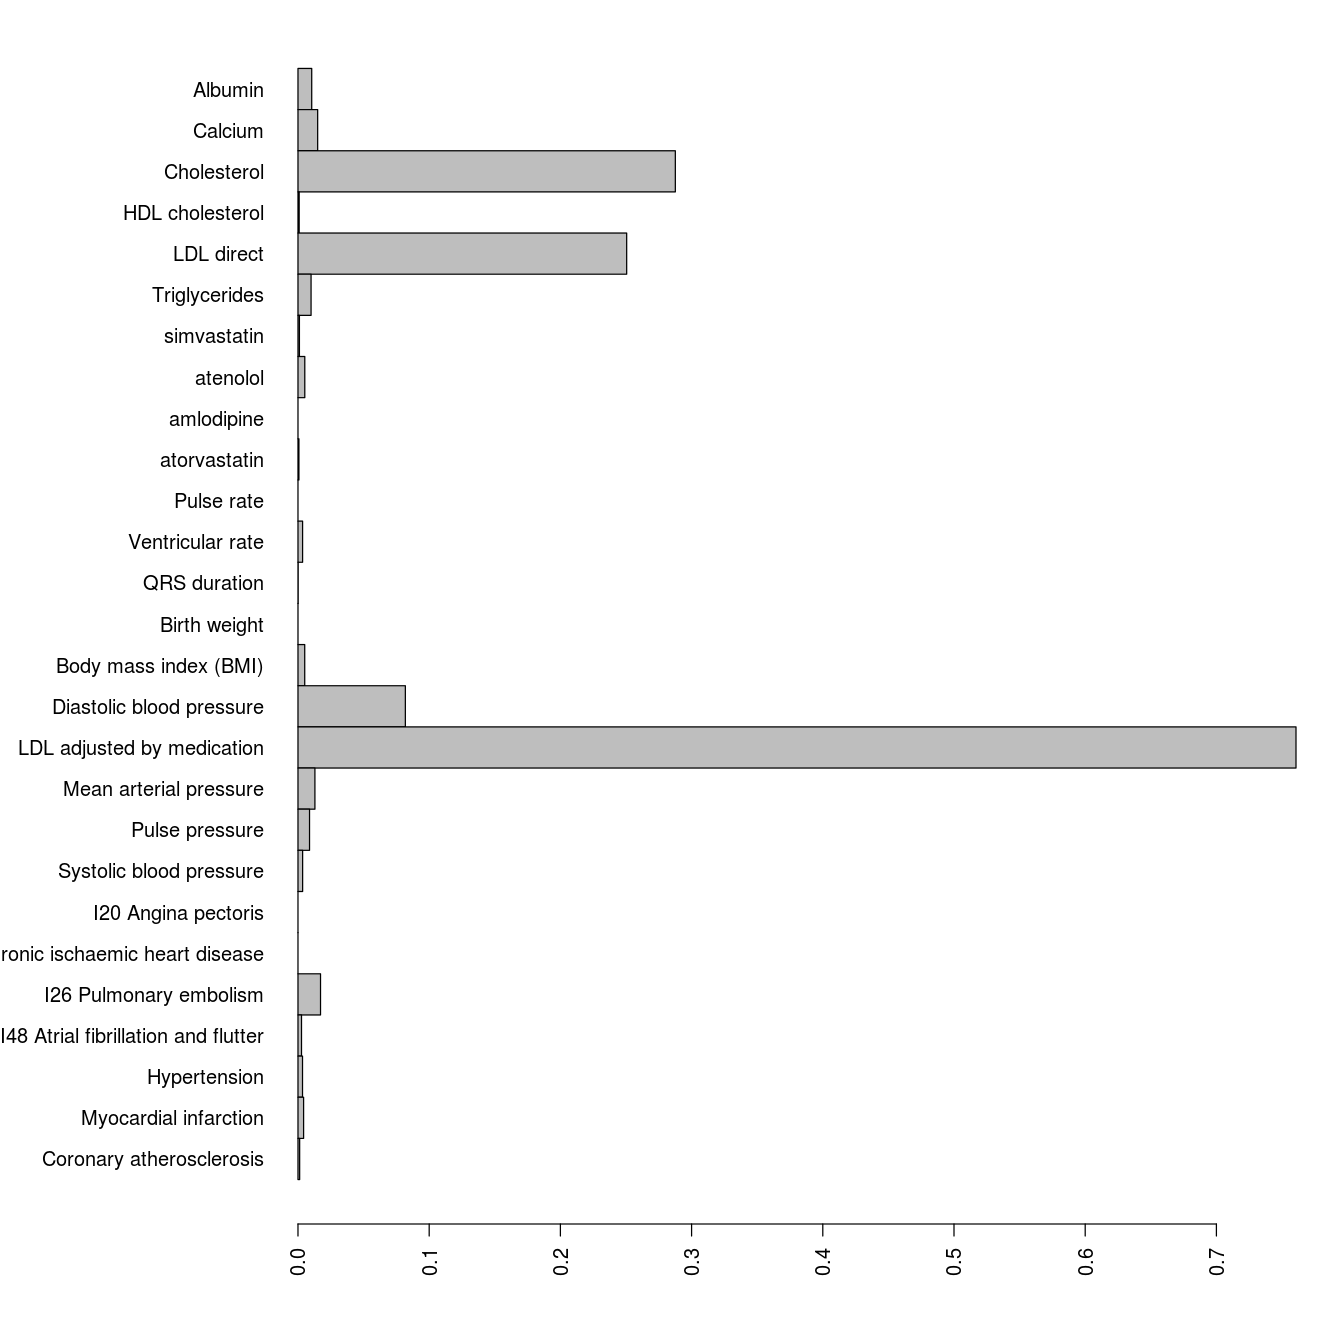

In [368]:
class2plot = 9
cluster2plot = 5

options(repr.plot.width = 11, repr.plot.height = 11)

pheatmap(t(as.matrix(toplot[ loci2class[ loci2class$cluster == cluster2plot, "id"],])), color = c("#ffffff", "#000000"), cluster_rows = FALSE , cluster_cols = FALSE, show_colnames = TRUE, show_rownames = TRUE)

par(mar = c(4,12,1,1))

tobar = som2cluster[som2cluster$cluster == cluster2plot,]
tobar = colMeans(trait2class[ tobar$som,])
barplot(as.numeric(tobar), horiz = TRUE, names.arg = colnames(trait2class), las = 2, ylim = c(ncol(trait2class), 0), space = 0, width = 1)


# SCRATCH

In [399]:
locus = "1_15163815_15363815"
moloc_list[[locus]]
moloc2signals[locus,]

$pvals
  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt
1                        0.0008678                        0.0007292
  biomarkers-30690-both_sexes-irnt biomarkers-30760-both_sexes-irnt
1                         0.001557                         0.001509
  biomarkers-30780-both_sexes-irnt biomarkers-30870-both_sexes-irnt
1                         0.003385                         0.000215
  categorical-20003-both_sexes-1140861958
1                                0.008078
  categorical-20003-both_sexes-1140866738
1                                  0.0151
  categorical-20003-both_sexes-1140879802
1                               7.797e-05
  categorical-20003-both_sexes-1141146234 continuous-102-both_sexes-irnt
1                                0.009351                       0.002652
  continuous-12336-both_sexes-irnt continuous-12340-both_sexes-irnt
1                         0.003812                          0.01686
  continuous-20022-both_sexes-irnt continuous-21001-both_sexes-irnt
1                         0.002036                         0.003386
  continuous-DBP-both_sexes-combined_medadj_irnt
1                                        0.00049
  continuous-LDLC-both_sexes-medadj_irnt
1                                0.00319
  continuous-MAP-both_sexes-combined_medadj_irnt
1                                      0.0001095
  continuous-PP-both_sexes-combined_medadj_irnt
1                                     0.0004377
  continuous-SBP-both_sexes-combined_medadj_irnt icd10-I20-both_sexes
1                                      9.835e-05             0.001951
  icd10-I25-both_sexes icd10-I26-both_sexes icd10-I48-both_sexes
1             0.008493            0.0004907             0.002009
  phecode-401-both_sexes phecode-411.2-both_sexes phecode-411.4-both_sexes
1               0.007401                 0.006344                   0.0148
  n_signif n_signals
1        0         0

$ppa
list()

biomarkers-30690-both_sexes-irnt;biomarkers-30780-both_sexes-irnt;categorical-20003-both_sexes-1140861958;categorical-20003-both_sexes-1140866738;categorical-20003-both_sexes-1141146234;continuous-102-both_sexes-irnt;continuous-DBP-both_sexes-combined_medadj_irnt;continuous-LDLC-both_sexes-medadj_irnt;continuous-MAP-both_sexes-combined_medadj_irnt;continuous-PP-both_sexes-combined_medadj_irnt;continuous-SBP-both_sexes-combined_medadj_irnt;icd10-I20-both_sexes;icd10-I25-both_sexes;phecode-401-both_sexes;phecode-411.2-both_sexes;phecode-411.4-both_sexes
1_15163815_15363815 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
                    biomarkers-30600-both_sexes-irnt;biomarkers-30680-both_sexes-irnt;biomarkers-30690-both_sexes-irnt;biomarkers-30760-both_sexes-irnt;biomarkers-30780-both_sexes-irnt;biomarkers-30870-both_sexes-irnt;categorical-20003-both_sexes-1140861958;categorical-20003-both_sexes-1141146234;continuous-DBP-both_sexes-combined_medadj_irnt;continuous-LDLC-both_sexes-medadj_irnt;continuous-MAP-both_sexes-combined_medadj_irnt;icd10-I20-both_sexes;icd10-I25-both_sexes;phecode-411.2-both_sexes;phecode-411.4-both_sexes
1_15163815_15363815 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
                    biomarkers-30600-both_sexes-irnt;biomarkers-30690-both_sexes-irnt;biomarkers-30760-both_sexes-irnt;biomarkers-30780-both_sexes-irnt;categorical-20003-both_sexes-1140866738;continuous-20022-both_sexes-irnt;continuous-DBP-both_sexes-combined_medadj_irnt;continuous-LDLC-both_sexes-medadj_irnt;continuous-MAP-both_sexes-combined_medadj_irnt;continuous-SBP-both_sexes-combined_medadj_irnt;icd10-I20-both_sexes;icd10-I25-both_sexes;phecode-401-both_sexes;phecode-411.2-both_sexes;phecode-411.4-both_sexes
1_15163815_15363815 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
                    biomarkers-30690-both_sexes-irnt;biomarkers-30760-both_sexes-irnt;biomarkers-30780-both_sexes-irnt;categorical-20003-both_sexes-1140861958;categorical-20003-both_sexes-1141146234;continuous-102-both_sexes-irnt;continuous-DBP-both_sexes-combined_medadj_irnt;continuous-LDLC-both_sexes-medadj_irnt;continuous-MAP-both_sexes-combined_medadj_irnt;continuous-PP-both_sexes-combined_medadj_irnt;continuous-SBP-both_sexes-combined_medadj_irnt;icd10-I20-both_sexes;icd10-I25-both_sexes;phecode-411.2-both_sexes;phecode-411.4-both_sexes
1_15163815_15363815 0                                                                                                                                                                                                                 

In [400]:
moloc_df[ moloc_df$n_signif == 0,]

locus                 chrom from      to        size  
1_15163815_15363815   1_15163815_15363815   1      15163815  15363815 200000
1_34814724_35030256   1_34814724_35030256   1      34814724  35030256 215532
1_79923249_80123249   1_79923249_80123249   1      79923249  80123249 200000
1_110908560_111108560 1_110908560_111108560 1     110908560 111108560 200000
1_166045909_166245909 1_166045909_166245909 1     166045909 166245909 200000
1_196018341_196218341 1_196018341_196218341 1     196018341 196218341 200000
1_211393573_211593573 1_211393573_211593573 1     211393573 211593573 200000
1_238590874_238790874 1_238590874_238790874 1     238590874 238790874 200000
1_241521457_241733007 1_241521457_241733007 1     241521457 241733007 211550
2_13595005_13795005   2_13595005_13795005   2      13595005  13795005 200000
2_35337986_35537986   2_35337986_35537986   2      35337986  35537986 200000
2_35939534_36139572   2_35939534_36139572   2      35939534  36139572 200038
2_38638506_38841112   2_38638506_38841112   2      38638506  38841112 202606
2_47213562_47413562   2_47213562_47413562   2      47213562  47413562 200000
2_52554700_52754700   2_52554700_52754700   2      52554700  52754700 200000
2_62410597_62610597   2_62410597_62610597   2      62410597  62610597 200000
2_63831759_64031759   2_63831759_64031759   2      63831759  64031759 200000
2_88389841_88641064   2_88389841_88641064   2      88389841  88641064 251223
2_107009519_107220168 2_107009519_107220168 2     107009519 107220168 210649
2_123262648_123462648 2_123262648_123462648 2     123262648 123462648 200000
2_142197550_142402503 2_142197550_142402503 2     142197550 142402503 204953
2_161554943_161754976 2_161554943_161754976 2     161554943 161754976 200033
2_170870668_171070668 2_170870668_171070668 2     170870668 171070668 200000
2_198683693_199010107 2_198683693_199010107 2     198683693 199010107 326414
2_239764383_239986775 2_239764383_239986775 2     239764383 239986775 222392
3_14076446_14276446   3_14076446_14276446   3      14076446  14276446 200000
3_33580389_33780389   3_33580389_33780389   3      33580389  33780389 200000
3_78358928_78755144   3_78358928_78755144   3      78358928  78755144 396216
3_86710136_86910136   3_86710136_86910136   3      86710136  86910136 200000
3_101786745_101986745 3_101786745_101986745 3     101786745 101986745 200000
⋮                     ⋮                     ⋮     ⋮         ⋮         ⋮     
14_59318274_59531448  14_59318274_59531448  14    59318274   59531448 213174
14_65619109_66120071  14_65619109_66120071  14    65619109   66120071 500962
14_96553724_96753724  14_96553724_96753724  14    96553724   96753724 200000
15_57770164_57970164  15_57770164_57970164  15    57770164   57970164 200000
15_65248484_65450330  15_65248484_65450330  15    65248484   65450330 201846
15_79945698_80145698  15_79945698_80145698  15    79945698   80145698 200000
15_96079966_96279966  15_96079966_96279966  15    96079966   96279966 200000
15_99996384_100301057 15_99996384_100301057 15    99996384  100301057 304673
16_19248876_19465222  16_19248876_19465222  16    19248876   19465222 216346
16_26177662_26377662  16_26177662_26377662  16    26177662   26377662 200000
16_46588255_46788255  16_46588255_46788255  16    46588255   46788255 200000
16_73812588_74012588  16_73812588_74012588  16    73812588   74012588 200000
16_76795693_76995693  16_76795693_76995693  16    76795693   76995693 200000
17_12055901_12255901  17_12055901_12255901  17    12055901   12255901 200000
17_30793228_30993228  17_30793228_30993228  17    30793228   30993228 200000
17_53818637_54018637  17_53818637_54018637  17    53818637   54018637 200000
17_70621707_70851210  17_70621707_70851210  17    70621707   70851210 229503
18_50731134_50993966  18_50731134_50993966  18    50731134   50993966 262832
18_71804385_72048446  18_71804385_72048446  18    71804385   72048446 244061
18_72989179_73189179  18_72989179_73189179  18    72989179   73189179 200000
19_5934498_6134498

# Compare with COLOC

In [75]:
coloc = fread("pipeline/2.1.coloc/coloc.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [76]:
totest   = moloc_df
totest$x = totest$n_signif / totest$n_signals
totest   = totest[order(totest$x, decreasing = TRUE),]

In [77]:
str(totest)

'data.frame':	2045 obs. of  35 variables:
 $ locus                                         : chr  "2_216043603_216433193" "5_32572263_33511769" "6_150852507_151218800" "10_105848645_107470555" ...
 $ chrom                                         : int  2 5 6 10 11 13 16 17 2 2 ...
 $ from                                          : int  216043603 32572263 150852507 105848645 106952692 22140151 83876225 58801973 3253632 65160344 ...
 $ to                                            : int  216433193 33511769 151218800 107470555 107522434 22527160 84092084 59598250 3748186 65486462 ...
 $ size                                          : int  389590 939506 366293 1621910 569742 387009 215859 796277 494554 326118 ...
 $ n_signif                                      : int  6 6 6 6 6 6 6 6 5 5 ...
 $ n_signals                                     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ biomarkers-30600-both_sexes-irnt              : num  0.000716 0.000232 0.001751 0.000247 0.000425 ...
 $ biomarkers-30

In [81]:
locus = "2_216043603_216433193"
moloc2signal_list[[locus]]
moloc_list[[locus]]
rowSums(moloc2signals[locus,])

[[1]]
[1] "biomarkers-30690-both_sexes-irnt;biomarkers-30780-both_sexes-irnt;continuous-LDLC-both_sexes-medadj_irnt;continuous-PP-both_sexes-combined_medadj_irnt"

$pvals
  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt
1                        0.0007158                        9.091e-05
  biomarkers-30690-both_sexes-irnt biomarkers-30760-both_sexes-irnt
1                        3.604e-08                        0.0003457
  biomarkers-30780-both_sexes-irnt biomarkers-30870-both_sexes-irnt
1                        3.895e-09                        2.776e-05
  categorical-20003-both_sexes-1140861958
1                                0.001887
  categorical-20003-both_sexes-1140866738
1                                 0.01208
  categorical-20003-both_sexes-1140879802
1                                0.004652
  categorical-20003-both_sexes-1141146234 continuous-102-both_sexes-irnt
1                                0.003394                       0.001667
  continuous-12336-both_sexes-irnt continuous-12340-both_sexes-irnt
1                         0.003317                        0.0003395
  continuous-20022-both_sexes-irnt continuous-21001-both_sexes-irnt
1                         0.002086                        0.0004127
  continuous-DBP-both_sexes-combined_medadj_irnt
1                                       0.001095
  continuous-LDLC-both_sexes-medadj_irnt
1                               2.17e-12
  continuous-MAP-both_sexes-combined_medadj_irnt
1                                      5.612e-07
  continuous-PP-both_sexes-combined_medadj_irnt
1                                     4.599e-38
  continuous-SBP-both_sexes-combined_medadj_irnt icd10-I20-both_sexes
1                                      2.749e-19             0.001705
  icd10-I25-both_sexes icd10-I26-both_sexes icd10-I48-both_sexes
1            1.143e-07             0.003585             0.004655
  phecode-401-both_sexes phecode-411.2-both_sexes phecode-411.4-both_sexes
1               0.001548                2.988e-06                1.911e-08
  n_signif n_signals
1        6         1

$ppa
$ppa[[1]]
[1] "biomarkers-30690-both_sexes-irnt"             
[2] "biomarkers-30780-both_sexes-irnt"             
[3] "continuous-LDLC-both_sexes-medadj_irnt"       
[4] "continuous-PP-both_sexes-combined_medadj_irnt"

2_216043603_216433193 
                    4

# SCRATCH:
- Create functions to run coloc

In [401]:
suppressPackageStartupMessages(library(moloc))

In [408]:
get_gwas_data = function(coord, gwas_file)
{
    my_head              = colnames(fread(cmd = paste("zcat", gwas_file, "|", "head -n 2"), sep = "\t", header = TRUE, data.table = FALSE))
    gwas_data            = suppressWarnings(tabix.read.table(gwas_file, coord, col.names = TRUE, stringsAsFactors = FALSE))
    colnames(gwas_data)  = my_head
    gwas_data$variant_id = paste(gwas_data$chr, gwas_data$pos, gwas_data$ref, gwas_data$alt, sep = "_")
    rownames(gwas_data)  = gwas_data$variant_id
    
    return(gwas_data)
}

create_dataset = function(study, totest, pop, manifest)
{
    trait_type = manifest[study, "trait_type"]
    x          = totest[[study]]
    x          = x[ x$pval_heterogeneity >= 1e-6,]
    dataset    = data.frame(SNP  = x$variant_id, 
                            A1   = x$ref       ,
                            A2   = x$alt       ,
                            BETA = x$beta_meta ,
                            SE   = x$se_meta   ,
                            PVAL = x$pval_meta ,
                            N    = manifest[study, "n_cases_meta"]
                           )
    dataset$MAF = ifelse(test = trait_type %in% c("categorical", "icd10", "phecode"), 
                         yes  = x$af_cases_meta, 
                         no   = x$af_meta)
    
    return(dataset)
}

combine_moloc = function(moloc, gwas2pval)
{
    ppa_max = moloc$priors_lkl_ppa
    pvals   = gwas2pval
    ppa_max = ppa_max[which.max(ppa_max$PPA),]
    ppa     = lapply(unlist(strsplit(rownames(ppa_max), ",")), function(x){pvals[pvals$letter %in% unlist(strsplit(x, "")), "study"]})
    return(ppa)
}

run_moloc_by_pop = function(locus, datasets, gwas2pval)
{
    gwas2pval$moloc  = FALSE
    gwas2pval$letter = ""
    gwas2pval[ gwas2pval$pval <= 1e-7, "moloc" ] = TRUE
    gwas2pval[gwas2pval$moloc == TRUE, "letter"] = letters[1:nrow(gwas2pval[gwas2pval$moloc == TRUE,])]
    
    datasets = datasets[gwas2pval[gwas2pval$moloc == TRUE, "study"]]
    variants = Reduce(intersect, lapply(datasets, function(x){x$SNP}))
    
    message(length(datasets))
    
    if((length(variants) > 100)&(length(datasets) > 1))
    {
        if(length(datasets) <= 4)
        {
            message("AAAAAAAAAA")
            my_priors  = 1e-4 * 10^(-(1:length(datasets)) + 1)
            moloc      = moloc_test(datasets, priors = my_priors, prior_var = rep(0.01, length(datasets)))
            #moloc      = moloc_test(datasets, priors = my_priors, prior_var = rep(0.01, length(datasets)), save.SNP.info = TRUE)
            #return(moloc)
            moloc$gwas = gwas2pval
            ppa        = combine_moloc(moloc, gwas2pval)
        }else
        {
            my_combs = combn(gwas2pval[ gwas2pval$moloc == TRUE, "study"], 4, simplify = FALSE)
            
            ppa_list = lapply(my_combs, function(x)
            {
                gwas2pval_x        = gwas2pval[x, ]
                gwas2pval_x$letter = letters[1:nrow(gwas2pval_x)]
                datasets_x         = datasets [gwas2pval_x$study]
                my_priors          = 1e-4 * 10^(-(1:length(datasets_x)) + 1)
                moloc              = moloc_test(datasets_x, priors = my_priors, prior_var = rep(0.01, length(datasets_x)))
                ppa_x              = combine_moloc(moloc, gwas2pval_x)
                
                return(ppa_x)
            })
            
            to_out_list = list()
            for(x in ppa_list)
            {
                to_out_list = append(to_out_list, x)
            }

            to_out_list = unique(to_out_list)

            to_out = data.frame(x = 1:length(to_out_list), size = unlist(lapply(to_out_list, length)))
            to_out = to_out[order(to_out$size, decreasing = TRUE),]

            ppa_out = list()
            for(ii in to_out$x)
            {
                this = to_out_list[[ii]]
                if(length(this[this %in% unlist(ppa_out)]) == 0){ppa_out[[length(ppa_out) + 1]] = this}
            }    
            ppa = ppa_out
        }
    }else
	{
        ppa = as.list(gwas2pval[gwas2pval$moloc == TRUE, "study"])
	}
    
    out = list(gwas = data.frame(study      = gwas2pval$study, 
                                 pval       = gwas2pval$pval_meta,
                                 variant_id = gwas2pval$variant_id,
                                 moloc      = gwas2pval$moloc),
               ppa  = ppa
              )
    
    saveRDS(out, paste("pipeline/2.2.moloc/moloc_by_locus", paste(locus, "rds", sep = "."), sep = "/"))
    #return(out)
}

run_moloc_gwas = function(locus, loci, manifest)
{
    chrom           = loci    [locus , "chrom" ]
    from            = loci    [locus , "from"  ]
    to              = loci    [locus , "to"    ]
    coord           = paste0(chrom, ":", from, "-", to)
    pop             = "meta"
    totest          = lapply(rownames(manifest), function(study){get_gwas_data (coord, manifest[study, "sumstat_file"])})
    names(totest)   = rownames(manifest)
    datasets        = lapply(rownames(manifest), function(study){create_dataset(study, totest, pop, manifest)})
    names(datasets) = rownames(manifest)
    
    gwas2pval = as.data.frame(rbindlist(lapply(rownames(manifest), function(study)
    {
        x = totest[[study]]
        x = x[which.min(x$pval_meta), c("variant_id", "pval_meta")]
        x$study = study
        
        return(x)
    })), stringsAsFactors = FALSE)
    rownames(gwas2pval) = gwas2pval$study
    
    suppressMessages(run_moloc_by_pop(locus, datasets, gwas2pval))
    #run_moloc_by_pop(locus, datasets, gwas2pval)
}


locus1 = "1_965800_2544414"
locus2 = "1_106956847_107177386"

#x1 = run_moloc_gwas(locus1, loci, manifest)
x2 = run_moloc_gwas(locus2, loci, manifest)



In [409]:
x1
#x2

NULL

In [ ]:
moloc = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc/pipeline/2.2.moloc/moloc_by_locus/1_965800_2544414.rds")

In [ ]:

moloc

In [ ]:
x$best_snp

In [ ]:



a = x$priors_lkl_ppa
a[ order(a$PPA, decreasing = TRUE),]